<a href="https://colab.research.google.com/github/egorwar/HouseLoan/blob/main/HouseLoan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение Задачи о Выдаче Ипотечного Кредита методами Машинного Обучения

**Выполнили:**

*   Федоров Георгий, 341гр.
*   Ткачев Владимир, 341гр.
*   Павлов Анатолий, 341гр.

**Цель итоговой аттестационной работы:**

средствами алгоримтов машинного обучения решить задачу классификации:

по данной заявке на кредит
от клиента дать автоматический ответ: выдать заем или отказать.

**Ссылки:**

[используемый датасет](https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval)

# Подключение библиотек

In [ ]:
# для загрузки датасета
from google.colab import files
import os.path

In [ ]:
# основные библиотеки для повсеместного использования
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# вспомогательные модули для анализа данных
from scipy import stats             # для сравнения распределений с нормальным
from matplotlib_venn import venn2   # для построения диаграммы Венна

# для кодирования категориальных признаков
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# для нормализации / стандартизации признаков
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# для поиска выбросов
from sklearn.ensemble import IsolationForest

# для заполнения тривиальных пропусков
from sklearn.impute import SimpleImputer

# для заполнения сложных пропусков
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# для разделения данных
from sklearn.model_selection import train_test_split

# для построения пайплайнов
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# метрики (функции ошибки), методы их вычисления и визуализации
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# линейные модели
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# дерево и способ его презентации
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# ансамблевая модель
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
# спрятать предупреждения для большей презентабельности
import warnings
warnings.filterwarnings("ignore")

# Загрузка датасета

Для начала, загрузим тренировочный датасет:

In [ ]:
if not os.path.isfile("loan_sanction_train.csv"):
  files.upload()

Saving loan_sanction_train.csv to loan_sanction_train.csv


Прочитаем и проверим его:

In [ ]:
df = pd.read_csv("loan_sanction_train.csv", delimiter=',')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Загрузим также **тестовый** датасет.
В нём нет столбца таргета, и распределение не даёт новой информации - однако эти дополнительные строки можно использовать для тренировки вспомогательных моделей, которые будут заполнять нетривиальные пропуски.

In [ ]:
if not os.path.isfile("loan_sanction_test.csv"):
  files.upload()

Saving loan_sanction_test.csv to loan_sanction_test.csv


Прочитаем и проверим его:

In [ ]:
df_test = pd.read_csv("loan_sanction_test.csv", delimiter=',')
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


Создадим также "полный" датасет: в нём не будет таргета, а прочие признаки будут взяты как из тренировочной, так и из тестовой выборки.

In [ ]:
# индексом здесь делаем данный в датасете индекс
# для облегчения поиска и вставки
fulldf = pd.concat([df.drop(columns=['Loan_Status']).set_index('Loan_ID'),
                    df_test.set_index('Loan_ID')])
fulldf.reset_index(drop=True, inplace=True)
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             957 non-null    object 
 1   Married            978 non-null    object 
 2   Dependents         956 non-null    object 
 3   Education          981 non-null    object 
 4   Self_Employed      926 non-null    object 
 5   ApplicantIncome    981 non-null    int64  
 6   CoapplicantIncome  981 non-null    float64
 7   LoanAmount         954 non-null    float64
 8   Loan_Amount_Term   961 non-null    float64
 9   Credit_History     902 non-null    float64
 10  Property_Area      981 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 84.4+ KB


# Постановка задачи

**Задача:**

По данной характеристике на каждого кандидата принять решение, выдавать ли ему ссуду (ипотеку) на недвижимость.

**Датасет:**

В имеющейся выборке 614 кандидатов, каждый описан уникальным идентификатором и 11 признаками (не считая индекса). Для каждого заявителя известно принятое решение о выдаче ссуды.

**Тип задачи:**

Бинарная классификация (таргет: выдана ли ссуда).

# Признаки

Опишем смысл каждого признака, рассмотрим возможные принимаемые значения, проведём первичный поверхностный анализ.

## **[Loan_ID]**

In [ ]:
df['Loan_ID'].describe()

count          614
unique         614
top       LP001002
freq             1
Name: Loan_ID, dtype: object

**Тип:** номинальный

**Значение:**

Уникальный идентификатор кандидата, представляет собой строку вида **LP*xxxxxx***, где ***xxxxxx*** - уникальный номер.

Судя по непоследовательному росту значения этого признака, имеющаяся выборка была случайным образом извлечена из более крупного набора данных.

**Пропуски:** 0

**Итог:**

Работать с текстовым идентификатором неудобно, проще с индексацией строк по умолчанию. **Удалим столбец.**

In [ ]:
df.drop(columns='Loan_ID', inplace=True)

## **[Gender]**

In [ ]:
df['Gender'].describe()

count      601
unique       2
top       Male
freq       489
Name: Gender, dtype: object

**Тип:** бинарный

**Значение:**

Строка, описывающая пол кандидата: ***Male*** - *мужчина* или ***Female*** - *женщина*.

Приблизительно **5 / 6** кандидатов - мужчины.

**Пропуски:** 13

Попробуем определить, влияет ли пол на принятие решения о выдаче ссуды.

<Axes: xlabel='Gender', ylabel='count'>

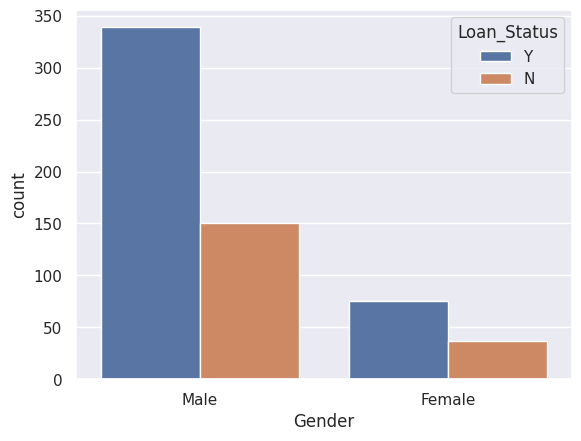

In [ ]:
sns.countplot(data=df, x='Gender', hue='Loan_Status')

In [ ]:
# Кажется, пол почти не влияет. Выясним подробнее:
gcor = df.value_counts(['Gender', 'Loan_Status'])

# отношение одобренных мужчин к неодобренным
coef_Male = gcor['Male']['Y'] / gcor['Male']['N']

# отношение одобренных женщин к неодобренным
coef_Female = gcor['Female']['Y'] / gcor['Female']['N']

print('Male:', coef_Male, '\nFemale:', coef_Female)

Male: 2.26 
Female: 2.027027027027027


Мужчинам ссуды одобряют незначительно чаще, что, скорее всего, не имеет значения.

**Итог:**

Очевидно, данный признак имеет минимальную связь с целевым. Больше о нём узнаем, проанализировав коррелированность с прочими признаками.

## **[Married]**

In [ ]:
df['Married'].describe()

count     611
unique      2
top       Yes
freq      398
Name: Married, dtype: object

**Тип:** бинарный

**Значение:**

Состоит ли кандидат в браке.

Примерно **2 / 3** кандидатов - состоит.

**Пропуски:** 3

<Axes: xlabel='Married', ylabel='count'>

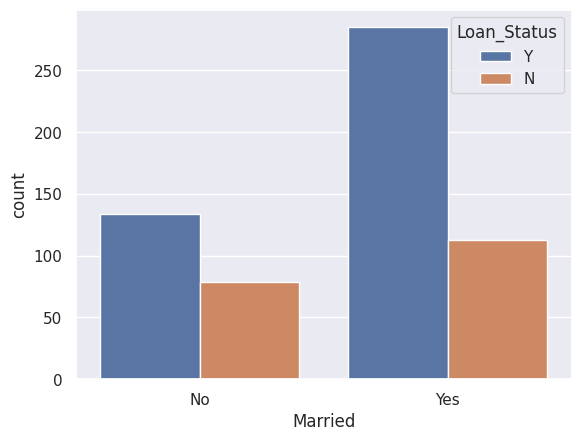

In [ ]:
sns.countplot(data=df, x='Married', hue='Loan_Status')

**Итог:**

Как видим, состоящих в браке почти в 2 раза больше, чем холостых. К тому же, последним значительно чаще отказывают.

Судя по всему, в данной ситуации быть женатым / замужней выгодно. Из этого можно сделать предположение, что следует предпочесть порядковое кодирование данного признака dummy-кодированию.

## **[Dependents]**

In [ ]:
df['Dependents'].describe()

count     599
unique      4
top         0
freq      345
Name: Dependents, dtype: object

**Тип:** категориальный

**Значение:**

Кол-во иждивенцев.

(Возможно, здесь имеются ввиду предполагаемые неплатёжеспособные сожители: дети, неработающий супруг, и т.д.)

**Пропуски:** 15

<Axes: xlabel='Dependents', ylabel='count'>

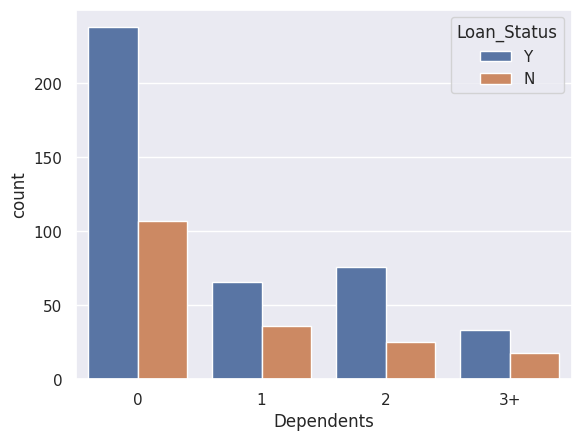

In [ ]:
sns.countplot(data=df, x='Dependents', hue='Loan_Status')

**Итог:**

Зависимость здесь достаточно сложная. Стоит подробнее проанализировать связи с прочими признаками.

## **[Education]**

In [ ]:
df['Education'].describe()

count          614
unique           2
top       Graduate
freq           480
Name: Education, dtype: object

**Тип:** бинарный

**Значение:**

Наличие (высшего) образования.

**Пропуски:** 0

<Axes: xlabel='Education', ylabel='count'>

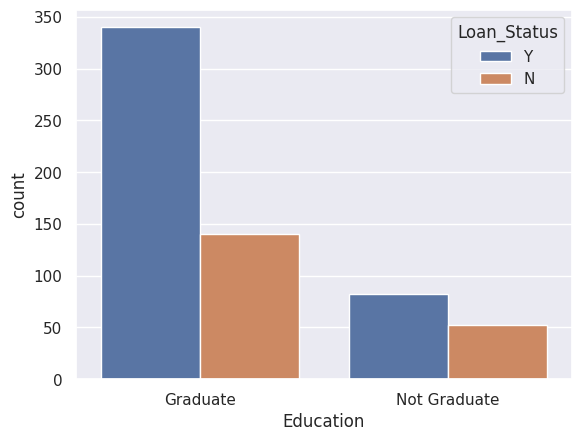

In [ ]:
sns.countplot(data=df, x='Education', hue='Loan_Status')

**Итог:**

Очевидно, кандидатам без высшего образования будут чаще отказывать. Видимо, также следует закодировать порядково.

## **[Self_Employed]**

In [ ]:
df['Self_Employed'].describe()

count     582
unique      2
top        No
freq      500
Name: Self_Employed, dtype: object

**Тип:** бинарный

**Значение:**

Является ли кандидат самозанятым.

**Пропуски:** 32

<Axes: xlabel='Self_Employed', ylabel='count'>

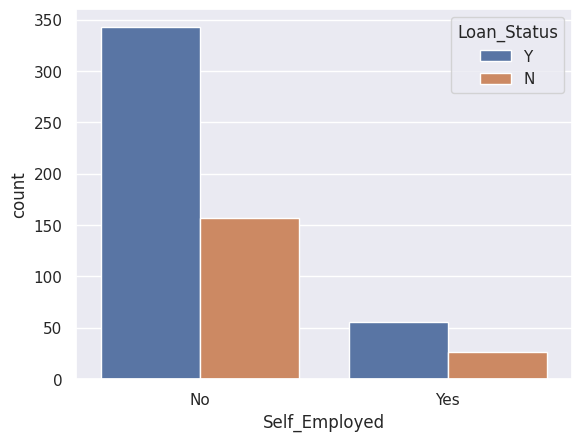

In [ ]:
sns.countplot(data=df, x='Self_Employed', hue='Loan_Status')

**Итог:**

Судя по всему, таргет не зависит от данного признака.

Следует рассмотреть связи с другими признаками - в особенности, с уровнем дохода.

## **[ApplicantIncome]**

In [ ]:
df['ApplicantIncome'].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

**Тип:** количественный

**Значение:**

Доход кандидата - целое положительное число. В тестовом датасете, не рассматриваемом в данной задаче, существуют значения 0, т.е. нижняя граница - 0.

**Пропуски:** 0

<Axes: xlabel='Loan_Status', ylabel='ApplicantIncome'>

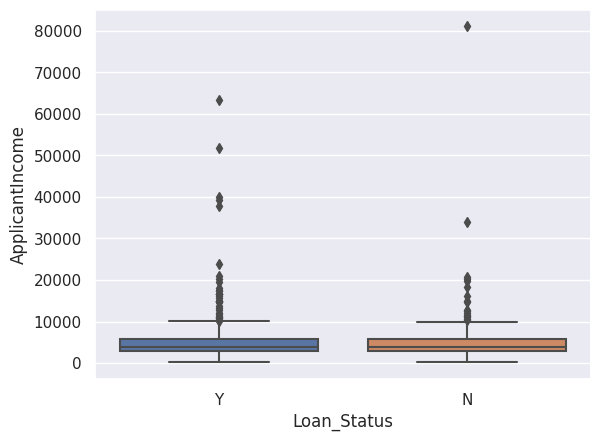

In [ ]:
sns.boxplot(data=df, y='ApplicantIncome', x='Loan_Status')

Неожиданно, но похоже доход кандидата совершенно не влияет на итоговое решение.

---

Посмотрим, как распределён этот признак:

<Axes: xlabel='ApplicantIncome', ylabel='Density'>

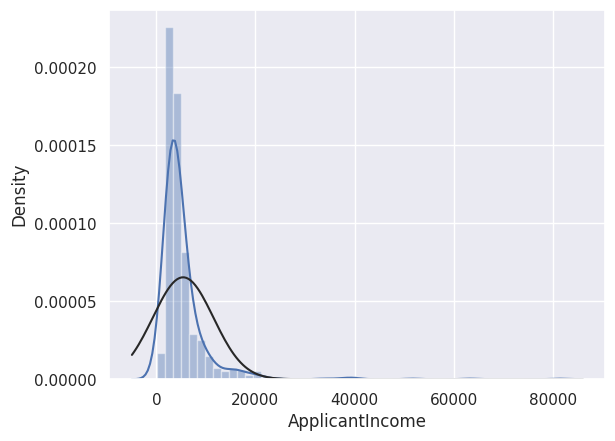

In [ ]:
# здесь и далее: на графике чёрная кривая - нормальное распредление для сравнения
sns.distplot(df['ApplicantIncome'], fit=stats.norm)

In [ ]:
print("Коэффициент асимметрии:\t", df['ApplicantIncome'].skew())
print("Коэффициент эксцесса:\t", df['ApplicantIncome'].kurt())

Коэффициент асимметрии:	 6.539513113994625
Коэффициент эксцесса:	 60.54067593369113


<Axes: xlabel='ApplicantIncome', ylabel='Density'>

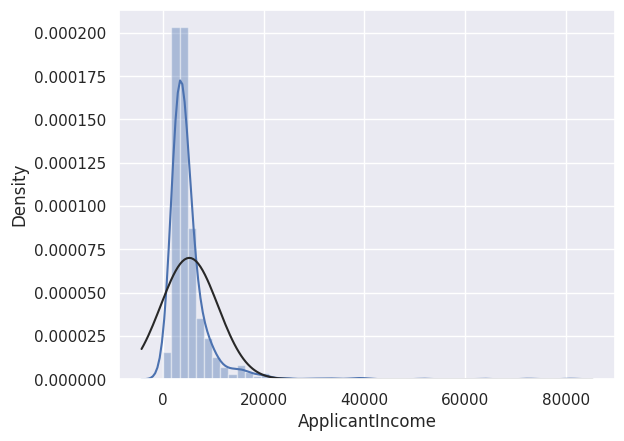

In [ ]:
sns.distplot(fulldf['ApplicantIncome'], fit=stats.norm)

Распределение отклоняется влево и чрезмерно "заострено", но по форме напоминает логнормальное. В таком случае, для улучшения коррелированности и более надёжного анализа рекомендуют лог-трансформировать признак.

<Axes: xlabel='ApplicantIncome', ylabel='Density'>

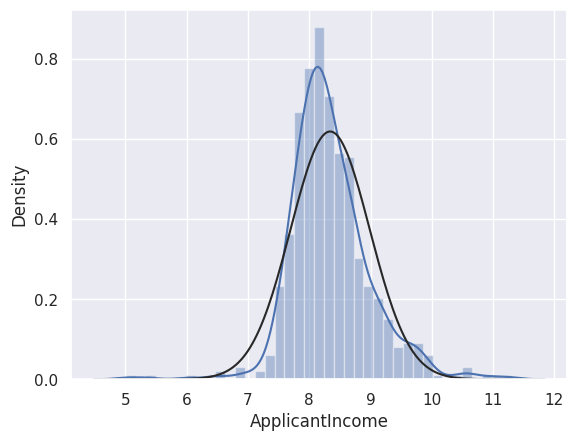

In [ ]:
# cоздадим его копию и попробуем это сделать:
log_income = pd.Series(np.log(df['ApplicantIncome'] + 1))
sns.distplot(log_income, fit=stats.norm)

In [ ]:
print("Коэффициент асимметрии после лог-трансформации:\t", log_income.skew())
print("Коэффициент эксцесса после лог-трансформации:\t", log_income.kurt())

Коэффициент асимметрии после лог-трансформации:	 0.4821279953732817
Коэффициент эксцесса после лог-трансформации:	 3.678710687140339


<Axes: xlabel='ApplicantIncome', ylabel='Density'>

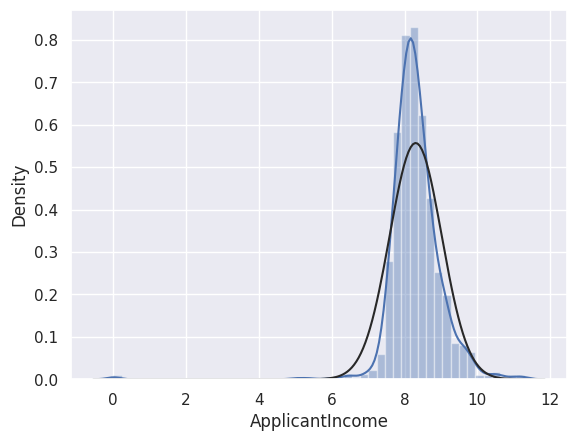

In [ ]:
log_income_full = pd.Series(np.log(fulldf['ApplicantIncome'] + 1))
sns.distplot(log_income_full, fit=stats.norm)

Получилось не очень хорошо, но распределение стало гораздо ближе к нормальному. Cтоит заменить оригинальный признак на лог-трансформированный.

**Итог:**

Признак, хоть напрямую и не влияет на таргет, кажется важным - не зря же компания-владелец датасета (судя по отсутствию пропусков) сделала этот пункт анкетирования обязательным.

Стоит изучить его связь с прочими.

Интерес представляет значительное число выбросов - с ними разберёмся на соответствующем этапе.

## **[CoapplicantIncome]**

In [ ]:
df['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

**Тип:** количественный

**Значение:**

Доход (сожителя?) - судя по всему, целое положительное число.

**Пропуски:** 0

Нижняя граница - 0, судя по отсутствию пропусков её можно трактовать по-разному:

1. Сожитель может и быть, но дохода он не имеет (тогда этот признак должен быть тесно связан с количеством иждивенцев: 0 дохода = хотя бы 1 иждивенец).
2. Сожителя нет (тогда иждивенцы рассматриваются отдельно, а этот столбец - только для платёжеспособных сожителей).

Проверим связь с иждивенцами, что поможет нам выбрать верную гипотезу:

In [ ]:
# посмотрим пересечение между:
# - множеством индексов кандидатов, у которых более 0 иждивенцев
# и
# - множеством индексов кандидатов, имеющих доход сожителя = 0

len(df[(df['Dependents'] != '0') & (df['CoapplicantIncome'] == 0)])

116

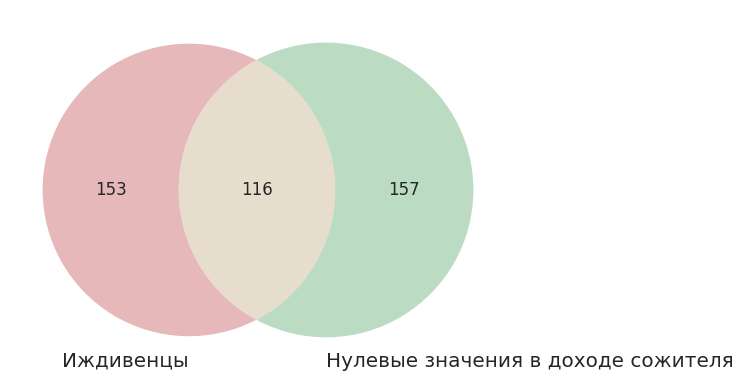

In [ ]:
# для наглядности построим диаграмму Эйлера-Венна
venn2([set(df[df['Dependents'] != '0'].index.to_list()),
       set(df[df['CoapplicantIncome'] == 0].index.to_list())],
       set_labels=('Иждивенцы', 'Нулевые значения в доходе сожителя')
     )

Судя по всему, связи между этими колонками нет, и верна вторая гипотеза:

> иждивенцы рассматриваются отдельно, а этот столбец - только для платёжеспособных сожителей.

Впредь *неплатёжеспособных сожителей* будем называть *иждивенцами*, их кол-во рассматривается в столбце **Dependents**.

*Платёжеспособных сожителей* будем называть *сожителями*, их доход рассматривается в столбце **CoapplicantIncome**.

Мы ничего не знаем о количестве сожителей, но это, наверное, не имеет значения.

**Тогда 0 означает отсутствие сожителей, а любое ненулевое значение - суммарный доход любого их числа.**

In [ ]:
# В таком случае создадим бинарный столбец Coapplicants:
# 'Yes' - если CoapplicantIncome > 0
# 'No' - если CoapplicantIncome = 0

df['Coapplicants'] = np.sign(df['CoapplicantIncome'])

In [ ]:
np.corrcoef(df['Coapplicants'], df['CoapplicantIncome'])

array([[1.        , 0.49613031],
       [0.49613031, 1.        ]])

Получается, созданный признак слишком коррелирован с исходным, а после избавления от выбросов и кодирования коррелированность возрастёт до 0.80

In [ ]:
df.drop(columns='Coapplicants', inplace=True)

<Axes: xlabel='Loan_Status', ylabel='CoapplicantIncome'>

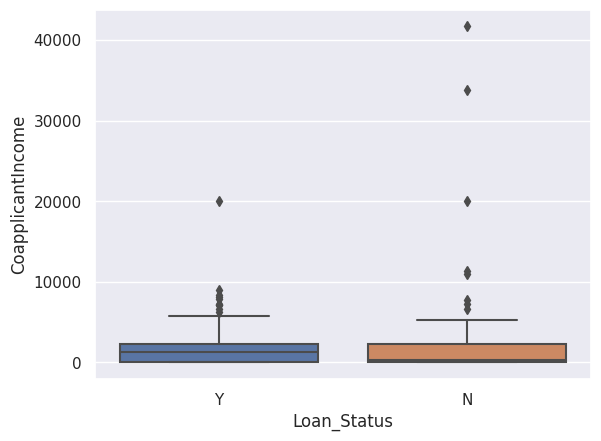

In [ ]:
sns.boxplot(data=df, y='CoapplicantIncome', x='Loan_Status')

Доход сожителей имеет неясную связь с таргетом.

---

Посмотрим, как распределён этот признак:

<Axes: xlabel='CoapplicantIncome', ylabel='Density'>

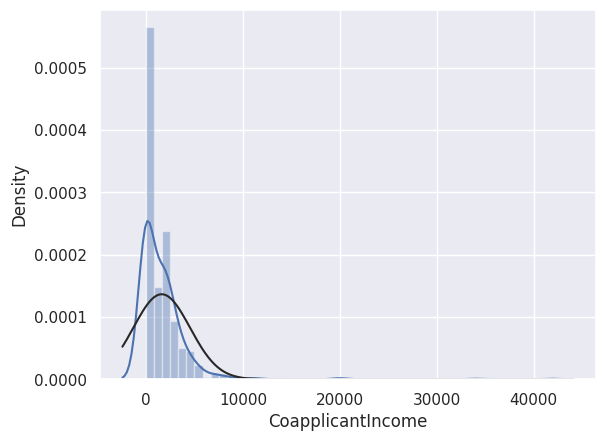

In [ ]:
sns.distplot(df['CoapplicantIncome'], fit=stats.norm)

<Axes: xlabel='CoapplicantIncome', ylabel='Density'>

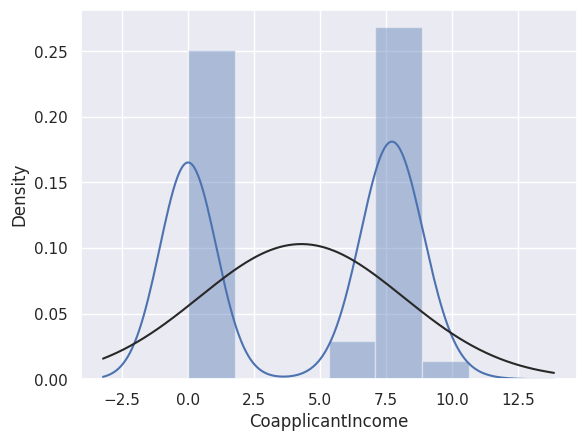

In [ ]:
# лог-трансформируем признак, сдвинув его на единицу
# (чтобы избавиться от логарифмов от нуля, что вызовет ошибку)
log_coincome = pd.Series(np.log(df['CoapplicantIncome'] + 1))
sns.distplot(log_coincome, fit=stats.norm)

<Axes: xlabel='CoapplicantIncome', ylabel='Density'>

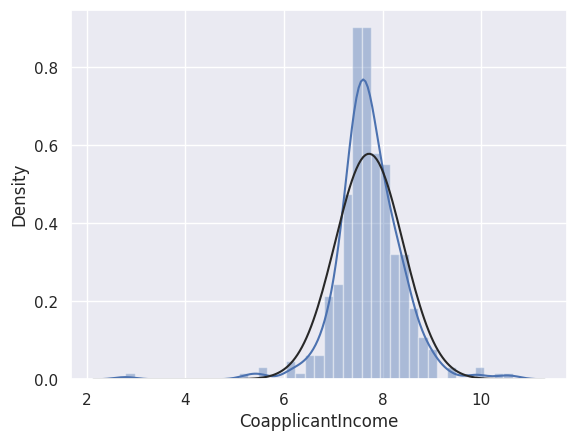

In [ ]:
# судя по всему, бывшие нули всё портят - попробуем без них:
log_coincome2 = pd.Series(np.log(df[df['CoapplicantIncome'] != 0]['CoapplicantIncome']))
sns.distplot(log_coincome2, fit=stats.norm)

Как видим, признак без нулей прекрасно лог-трансформируется, однако нули дают второй пик распределению, лишая возможности его трансформировать...

**Итог:**

Непростой признак.

С таргетом вряд-ли коррелирует, стоит обратить внимание на связь с другими признаками.

## **[LoanAmount]**

In [ ]:
df['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

**Тип:** количественный

**Значение:**

Размер ссуды в тысячах (валюта не указана, но это не имеет значения)

**Пропуски:** 22

Интересная ситуация с пропусками: почему они вообще есть?

Неужели компания готова при каких-то обстоятельствах выдавать ссуду на *любую* сумму?

Может быть, эти пропуски - утерянные данные?

Возможно ли, что компания отказывает всем, кто не указал размер ссуды?

In [ ]:
# давайте это выясним
df[df['LoanAmount'].isna()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
35,Male,Yes,0,Graduate,No,2275,2067.0,NaN,360.0,1.0,Urban,Y
63,Male,Yes,1,Graduate,No,4945,0.0,NaN,360.0,0.0,Rural,N
81,Male,Yes,1,Graduate,Yes,2395,0.0,NaN,360.0,1.0,Semiurban,Y
95,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
102,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
103,Male,Yes,0,Graduate,No,4652,3583.0,NaN,360.0,1.0,Semiurban,Y
113,Female,No,1,Graduate,Yes,7451,0.0,NaN,360.0,1.0,Semiurban,Y
127,Male,No,0,Graduate,No,3865,1640.0,NaN,360.0,1.0,Rural,Y
202,Male,Yes,3+,Not Graduate,No,3992,0.0,NaN,180.0,1.0,Urban,N


Нет, таким кандидатам вполне активно выдают ссуды.

---

<Axes: xlabel='Loan_Status', ylabel='LoanAmount'>

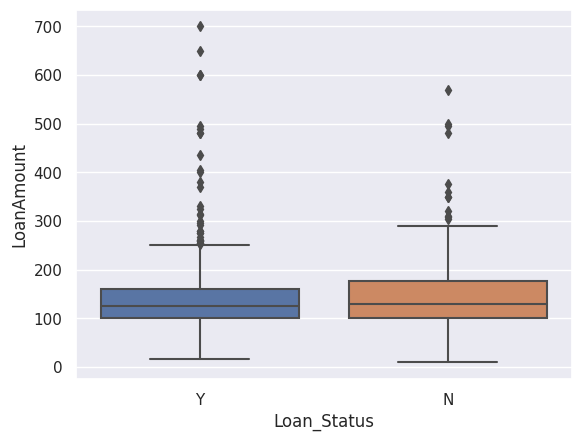

In [ ]:
sns.boxplot(data=df, y='LoanAmount', x='Loan_Status')

Коррелированность с таргетом опять не видна,

но стоит обратить внимание на выбросы - с ними разберемся позже.

<Axes: xlabel='LoanAmount', ylabel='Density'>

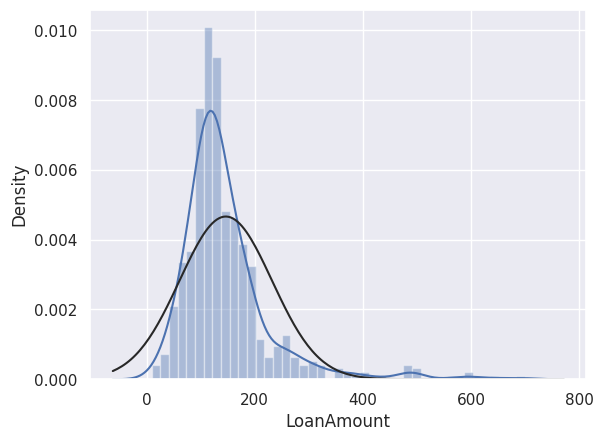

In [ ]:
sns.distplot(df['LoanAmount'], fit=stats.norm)

Также, распределение можно лог-трансформировать.

<Axes: xlabel='LoanAmount', ylabel='Density'>

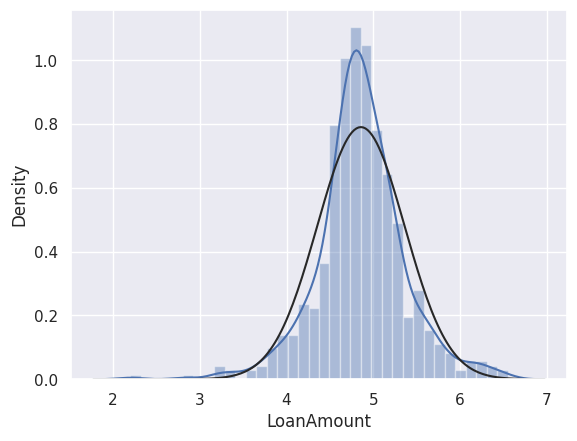

In [ ]:
log_loan = pd.Series(np.log(df['LoanAmount']))
sns.distplot(log_loan, fit=stats.norm)

**Итог:**

Неясна природа пропусков, возможно это реально утерянные данные.
Однако это маловероятно - скорее всего, данные собирались и хранились электронно. Может, в данном контексте пропуск означает, что кандидат согласен на ссуду любого размера?

Стоит заняться выбросами.

## **[Loan_Amount_Term]**

In [ ]:
df['Loan_Amount_Term'].describe()

count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64

**Тип:** количественный

**Значение:**

На сколько месяцев берется ссуда.

**Пропуски:** 14

<Axes: xlabel='Loan_Amount_Term', ylabel='Count'>

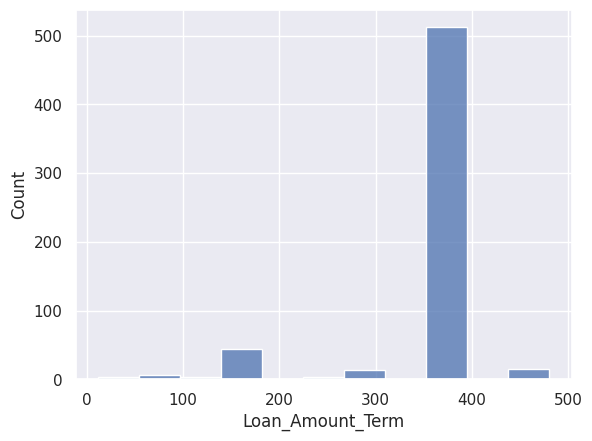

In [ ]:
# посмотрим распределение
sns.histplot(df['Loan_Amount_Term'])

In [ ]:
df['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

Очевидно, ссуда берётся на срок от года до 40 лет, с шагом пол-года.

Из-за этой особенности признака разумным кажется в качестве нормализации привести месяцы к годам, разделив на 12.

Посмотрим связь с таргетом:

<Axes: xlabel='Loan_Amount_Term', ylabel='count'>

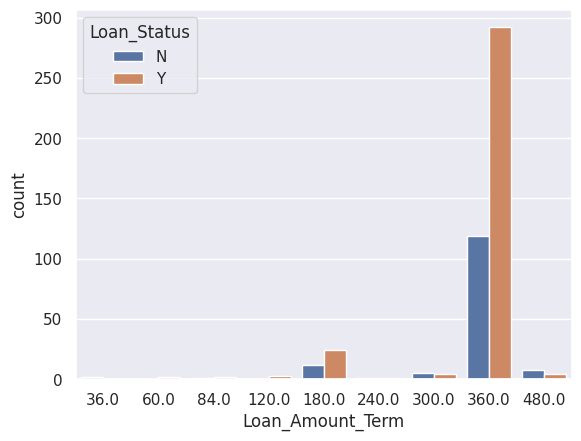

In [ ]:
sns.countplot(data=df.dropna(), x='Loan_Amount_Term', hue='Loan_Status')

In [ ]:
# Если перевести месяцы в годы, это заменит нормализацию
df['Loan_Amount_Term'] = df['Loan_Amount_Term'] / 12

Сложно выявить связь.

Похоже, активнее всего выдают ссуды на 15 и на 30 лет.

**Итог:**

Интересно, что признак несёт категориальный смысл.

## **[Credit_History]**

In [ ]:
df['Credit_History'].describe()

count    564.000000
mean       0.842199
std        0.364878
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Credit_History, dtype: float64

**Тип:** бинарный

**Значение:**

Соответствует ли кредитная история требованиям.

Требования эти нам не известны, их предъявляет компания, оформляя этот признак в качестве вывода по каждому кандидату.

**Пропуски:** 50

<Axes: xlabel='Credit_History', ylabel='count'>

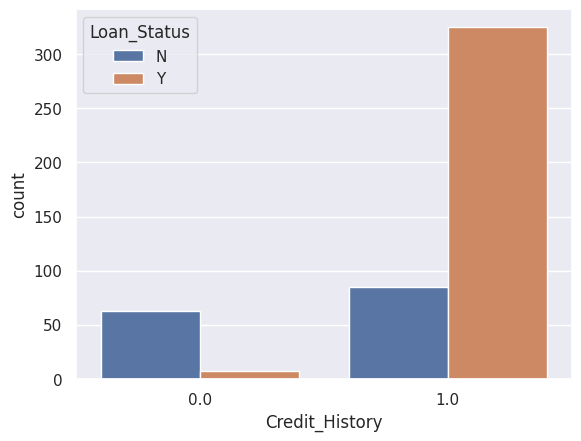

In [ ]:
sns.countplot(data=df.dropna(), x='Credit_History', hue='Loan_Status')

Наблюдается сильная зависимость таргета от данного признака:

> Если кредитная история кандидата неудовлетворительна, ему почти гарантированно откажут,
>
> в противном случае - скорее всего одобрят.



In [ ]:
# Попробуем увидеть какую-то связь между пропусками и численными признаками
credittest = df.copy()
credittest['marker'] = pd.isna(credittest['Credit_History'])

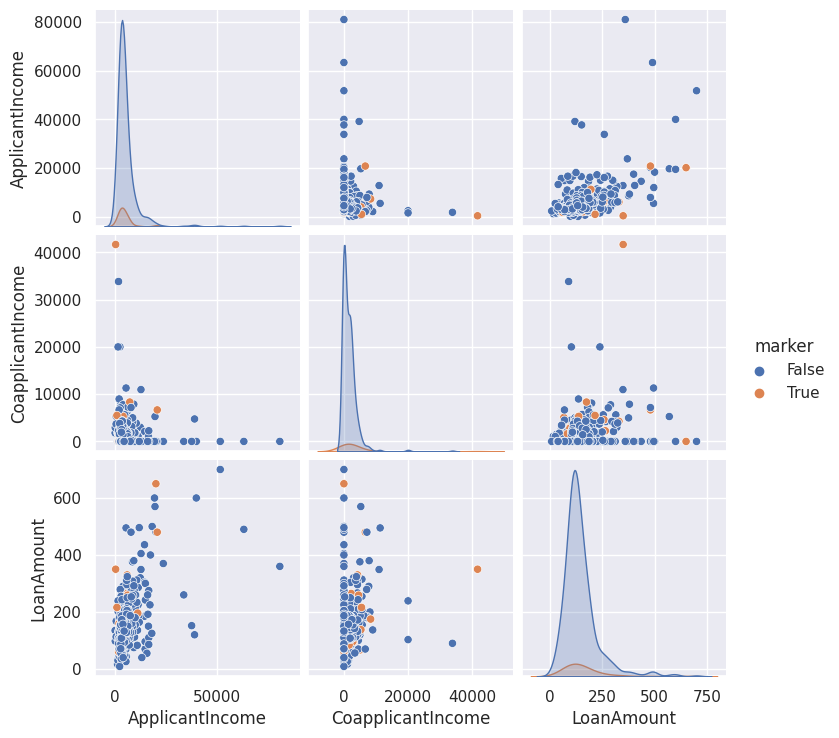

In [ ]:
sns.pairplot(credittest, vars=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], hue='marker')

Связь найти не удаётся. Остаётся искать корреляции, чем займёмся в соответствующем разделе.

**Итог:**

На данный момент это самый важный признак, почти гарантирующий исход каждого случая.

Пропусков, к сожалению, многовато - следует поискать прочие признаки с высокой коррелированностью с текущим.

Если таковых не найдётся, то возможно придётся удалять строки с пропусками, т.к. заполнять пропущенные значения такого важного признака приближёнными методами = сильно искажать модель.

## **[Property_Area]**

In [ ]:
df['Property_Area'].describe()

count           614
unique            3
top       Semiurban
freq            233
Name: Property_Area, dtype: object

In [ ]:
df['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

**Тип:** категориальный

**Значение:**

Размещение недвижимости:

> **Urban** - *город*,
>
>**Semiurban** - *пригород*,
>
>**Rural** - *сельская местность*.


**Пропуски:** 0

<Axes: xlabel='Property_Area', ylabel='count'>

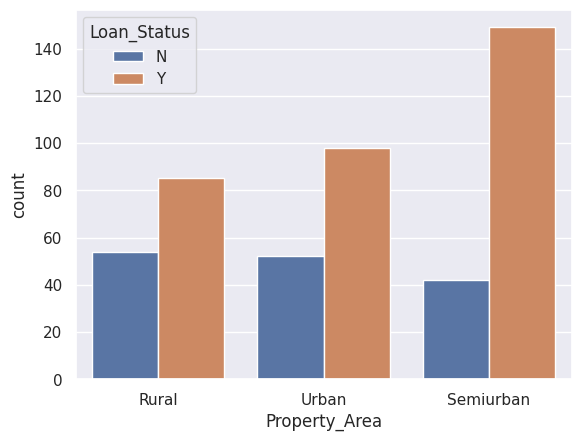

In [ ]:
sns.countplot(data=df.dropna(), x='Property_Area', hue='Loan_Status')

Пригородная недвижимость наиболее доступна для выдачи ссуды, городская и сельская - далее по убыванию вероятности одобрения.

**Итог:**

Достаточно важный признак: без выбросов, влияет на таргет.

Возможно, в случае применения регрессии следует закодировать его порядково (по вероятности одобрения).

# Целевой признак

## **[Loan_Status]**


**Тип:** бинарный

**Значение:**

Выдана ли ссуда кандидату (одобрена ли заявка): **Y / N**

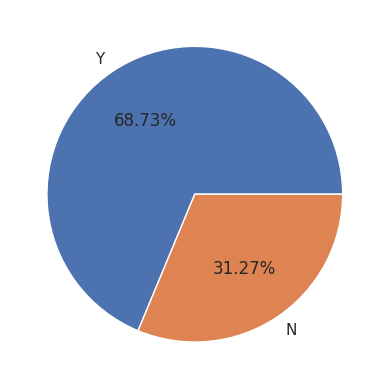

In [ ]:
plt.pie([len(df[df['Loan_Status'] == 'Y']), len(df[df['Loan_Status'] == 'N'])], labels = ['Y', 'N'], autopct='%.2f%%')
plt.show()

Как видим, одобренных заявок примерно в 2 раза больше, чем отклонённых.

# Оптимальное кодирование

С учётом вышесказанного, уже можно оформить некоторые вспомогательные методы для кодирования и лог-трансформирования признаков

In [ ]:
# порядково закодировать указанные столбцы:
def ordinalEncode(d, cols):
    d = d.copy()
    ord = OrdinalEncoder()
    d[cols] = ord.fit_transform(d[cols])

    return d

In [ ]:
# onehot-закодировать указанные столбцы:
def onehotEncode(d, cols):
    # получаем закодированные столбцы
    ohe = OneHotEncoder(sparse=False)
    encoded = pd.DataFrame(ohe.fit_transform(d[cols]))

    # добавляем к ним корректные индексы и заголовки
    encoded.columns = ohe.get_feature_names_out()
    encoded.index = d.index

    # заменяем ими исходные признаки в исходном датасете
    d = d.drop(columns=cols)
    d = pd.concat([d, encoded], axis=1)

    return d

In [ ]:
# заменяем количественные признаки лог-трансформированными версиями
# (для CoapplicantIncome это не имеет смысла)
def logApply(d):
    d = d.copy()
    d['ApplicantIncome'] = log_income
    d['LoanAmount'] = log_loan

    return d

# Выбросы

## [ВАРИАНТ 1] Через квантили

Определение выбросов "на глаз" в *scatterplot*-ах сложно и чревато предвзятостями.

Поэтому для избавления от выбросов воспользуемся известной эвристикой, определяющей выбросы через **межквартильное расстояние**:

In [ ]:
len(df)

614

In [ ]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
# определим функцию для возможного дальнейшего использования
def quantileOutliers(d):
    Q1 = d.quantile(0.25)  # первые квартили
    Q3 = d.quantile(0.75)  # третьи квартили

    IQR = Q3 - Q1  # межквартильные расстояния

    cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

    # оставляем только те записи, которые попадают в обозначенный промежуток по каждому признаку
    d = d[~((d[cols] < Q1 - 1.5 * IQR) | (d[cols] > Q3 + 1.5 * IQR)).any(axis=1)].copy()
    d.reset_index(drop=True, inplace=True)

    return d

In [ ]:
# не забудем сначала лог-трансформировать
# это снизит число выбросов
q = quantileOutliers(logApply(df))
len(q)

551

По данной эвристике, 63 кандидата - выбросы.

По сути, если решать задачу классифицирующими деревьями, выбросы не должны быть критичны - поэтому оригинальный датасет сохранили.

В любом случае, 63 выброса - очень много для такого маленького датасета, хотелось бы попробовать отобрать их тщательнее - например, изолирующим лесом.

## [ВАРИАНТ 2] Изолирующим лесом

Для удобства сначала выделим только требуемые признаки

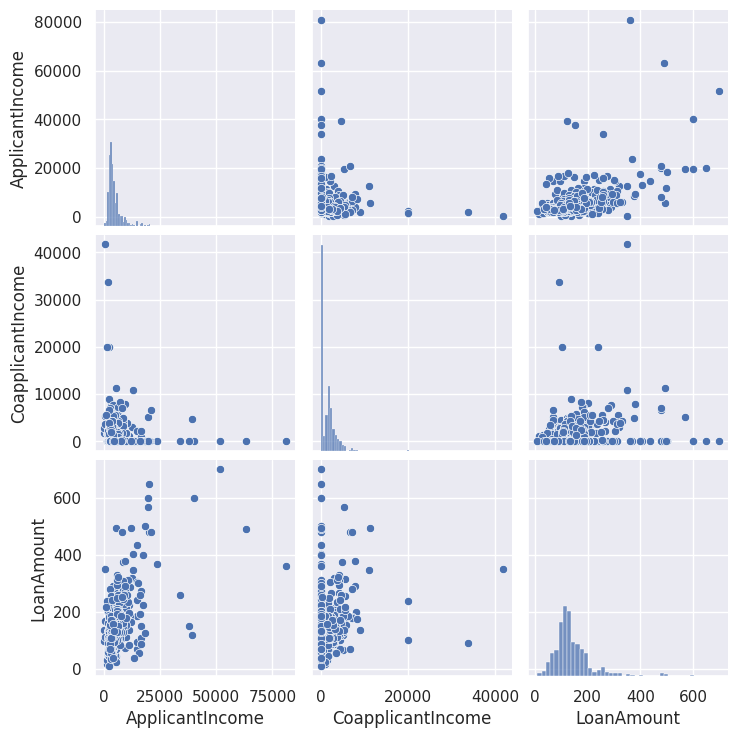

In [ ]:
sns.pairplot(df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

In [ ]:
# функция для применения изолирующего леса к требуемым признакам
# для поиска выбросов
def fitIsolation(d):
    isol = d[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']].copy()

    # изолирующий лес нетерпим к пропускам, заполним их
    isol['LoanAmount'].fillna(isol['LoanAmount'].mean(), inplace=True)

    model_IF = IsolationForest(contamination=0.03, random_state=42)
    model_IF.fit(isol)
    res = model_IF.predict(isol)

    isol['anomaly_scores'] = model_IF.decision_function(isol)
    isol['anomaly'] = res

    return isol


In [ ]:
# не забудем сначала лог-трансформировать
# это снизит число выбросов
isolated = fitIsolation(logApply(df))

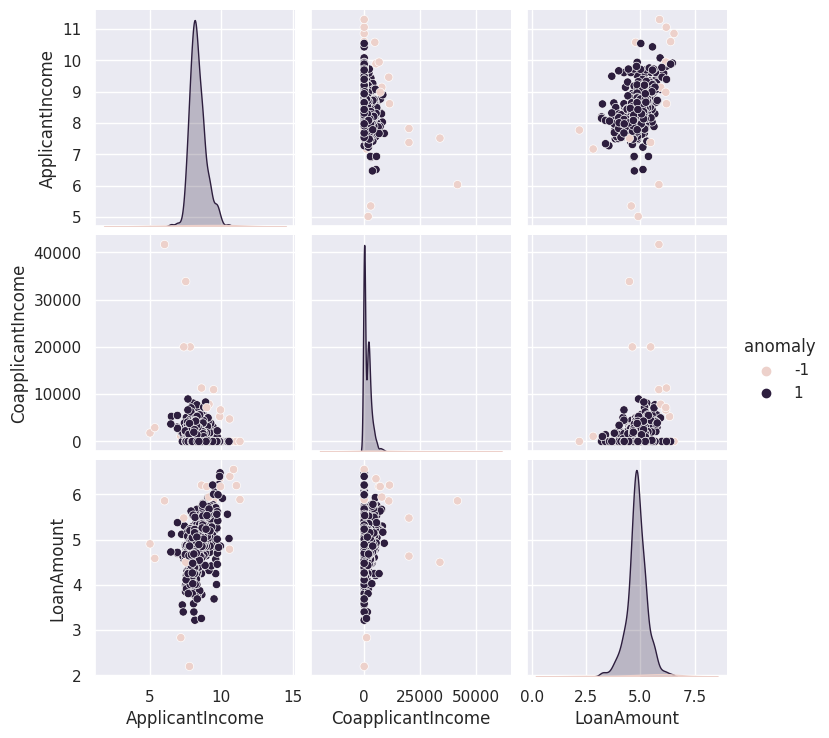

In [ ]:
sns.pairplot(isolated, vars=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], hue='anomaly')

In [ ]:
len(isolated[isolated['anomaly'] == -1])

19

После ручного подбора оптимального гиперпараметра (что удобно делать по графику выше) удалось найти критерий отбора, удаляющий лишь самые серьёзные выбросы.

Как видим, такой метод гораздо эффективнее квантилей - получилось спасти 44 объекта.

In [ ]:
# определим метод для удаления полученных выбросов из датасета
def isolationOutliers(d, by):
    d = d.drop(index=by[by['anomaly'] == -1].index)
    return d

In [ ]:
# Оболочка для автоматизированного использования в пайплайне
def isolationOutlierDetector(X, y):
    isolated_train = fitIsolation(X)
    X = isolationOutliers(X, isolated_train)
    y = isolationOutliers(y, isolated_train)
    return X, y

# Взаимосвязи

Теперь, после отдельного разбора каждого признака, стоит рассмотреть их зависимости друг от друга.

Для этого построим *heatmap* датасета.

Однако любые нечисловые признаки на таких графиках не отображаются. В обход этой проблемы, создадим две копии датасета: в одной все категориальные признаки закодируем **порядково**, а в другой - **dummy-кодированием**.

Для каждого варианта рассмотрим *heatmap*.

---

**Почему варианта два?**

Дело в том, что некоторые категориальные признаки могут коррелировать с другими **всецело** (и такую корреляцию мы увидим при порядковом кодировании), а некоторые - **частично**, только по принадлежности к одной категории.

## [ORDINAL] Общие зависимости

In [ ]:
# создаём копию для ordinal-энкодинга
# и порядково кодируем
ordinal = ordinalEncode(df, df.select_dtypes('object').columns)

In [ ]:
# заодно посмотрим, связан ли как-то факт пропуска кредитной истории с чем-либо
ordinal['Credit_History_na'] = pd.isna(ordinal['Credit_History'])
ordinal = ordinalEncode(ordinal, ['Credit_History_na'])

ordinal.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_na
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,NaN,30.0,1.0,2.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.0,30.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.0,30.0,1.0,2.0,1.0,0.0
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.0,30.0,1.0,2.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.0,30.0,1.0,2.0,1.0,0.0


<Axes: >

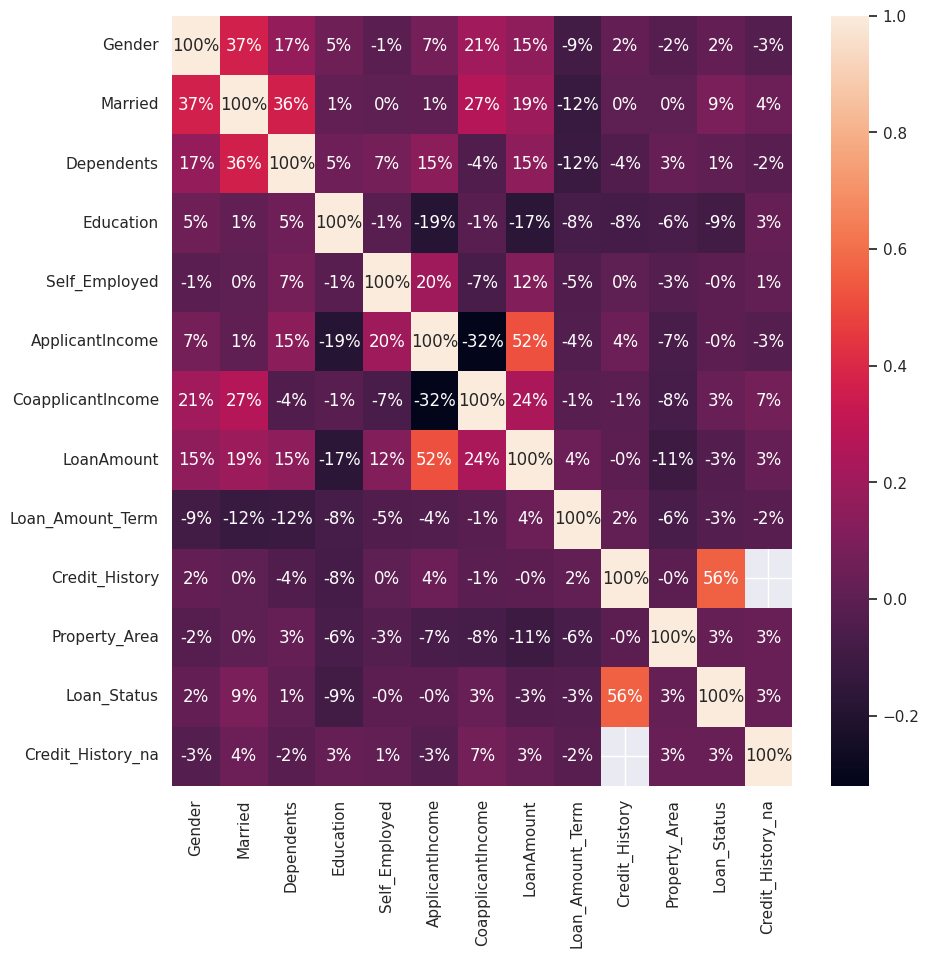

In [ ]:
# смотрим heatmap
plt.figure(figsize=(10,10))
sns.heatmap(ordinal.corr(method='spearman'), annot=True, fmt='.0%')

Перечислим самые сильные корреляции в порядке убывания модуля:

|признак|признак|корреляция|
|:--|:--|--:|
|Credit_History | Loan_Status | 59% |
|ApplicantIncome | LoanAmount | 46% |
|Gender|Married|38%|
|Married|Dependents|36%|
|ApplicantIncome|CoapplicantIncome|-31%|

Эти данные также будут крайне полезны при восстановлении пропусков.

Про пропуски кредитной истории узнать чего-либо не удалось.

## [ONEHOT] Частичные зависимости

In [ ]:
# создаём копию для onehot-энкодинга
# и закодируем
onehot = onehotEncode(df, df.select_dtypes('object').columns)

In [ ]:
# заодно посмотрим, связан ли как-то факт пропуска кредитной истории с чем-либо
onehot['Credit_History_na'] = pd.isna(onehot['Credit_History'])
onehot = onehotEncode(onehot, ['Credit_History_na'])

onehot.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Gender_nan,Married_No,Married_Yes,...,Self_Employed_No,Self_Employed_Yes,Self_Employed_nan,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y,Credit_History_na_False,Credit_History_na_True
0,5849,0.0,NaN,30.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,4583,1508.0,128.0,30.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3000,0.0,66.0,30.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,2583,2358.0,120.0,30.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,6000,0.0,141.0,30.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


<Axes: >

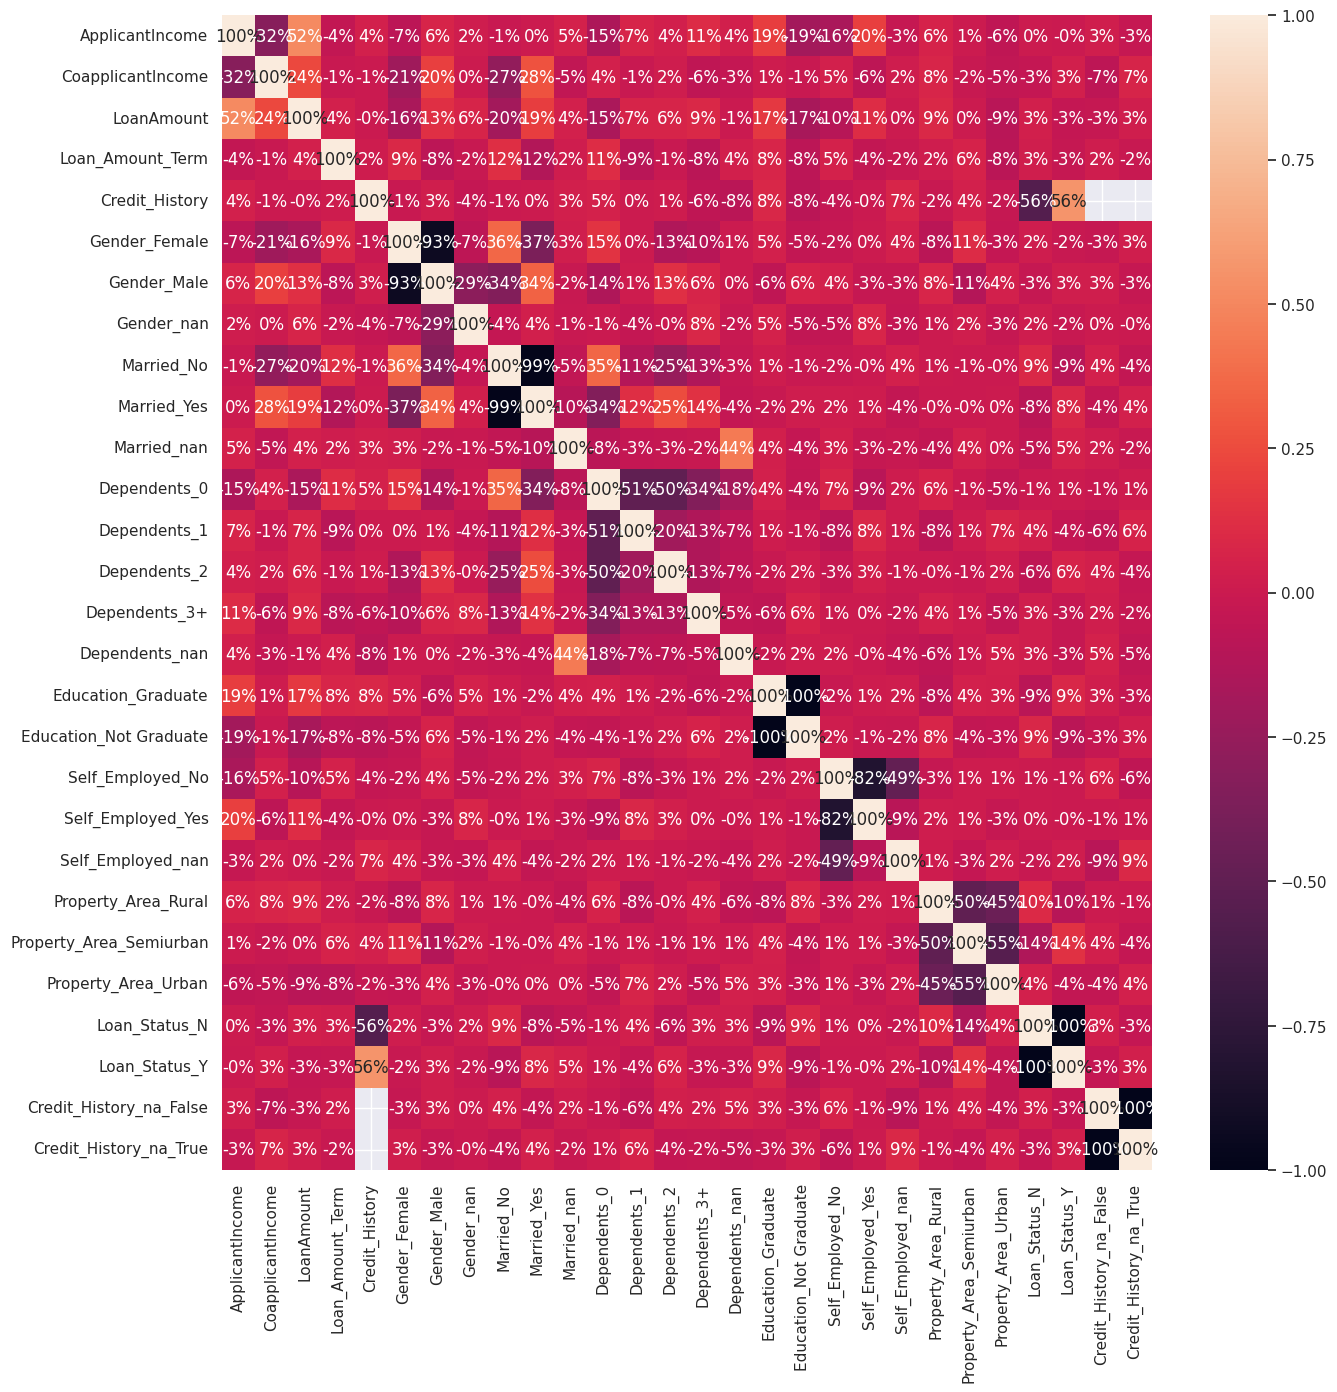

In [ ]:
# смотрим heatmap
plt.figure(figsize=(15,15))
sns.heatmap(onehot.corr(method='spearman'), annot=True, fmt='.0%')

Из такой карты мы можем вынести некоторую информацию о пропусках:

+ Пропуск пола несколько обратно коррелирует с мужским полом
+ Пропуск брака неплохо коррелирует с пропуском числа иждивенцев (хотя это нам мало чего даёт), также пропуск брака слабо обратно коррелирует с отсутствием брака
+ Число иждивенцев немного обратно коррелирует с их отсутствием.
+ Пропуск самозанятости несколько обратно коррелирует с её отсутствием.

В общем, подобные корреляции скорее лишь указывают на то, что какого-то значения определённого признака больше остальных.

Про пропуски кредитной истории узнать больше не удалось.

# Пропуски

## Простые случаи

Для начала попробуем найти более интересные, не обязательно линейные связи между признаками, которые помогут восстановить что-либо вручную.

Затем, когда останутся только неинтуитивные пропуски, натренируем какую-либо модель на расширенном датасете (train + test), и заполним оставшееся с её помощью.

In [ ]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
# всего строк с пропусками
len(df[df.isna().any(axis=1)])

134

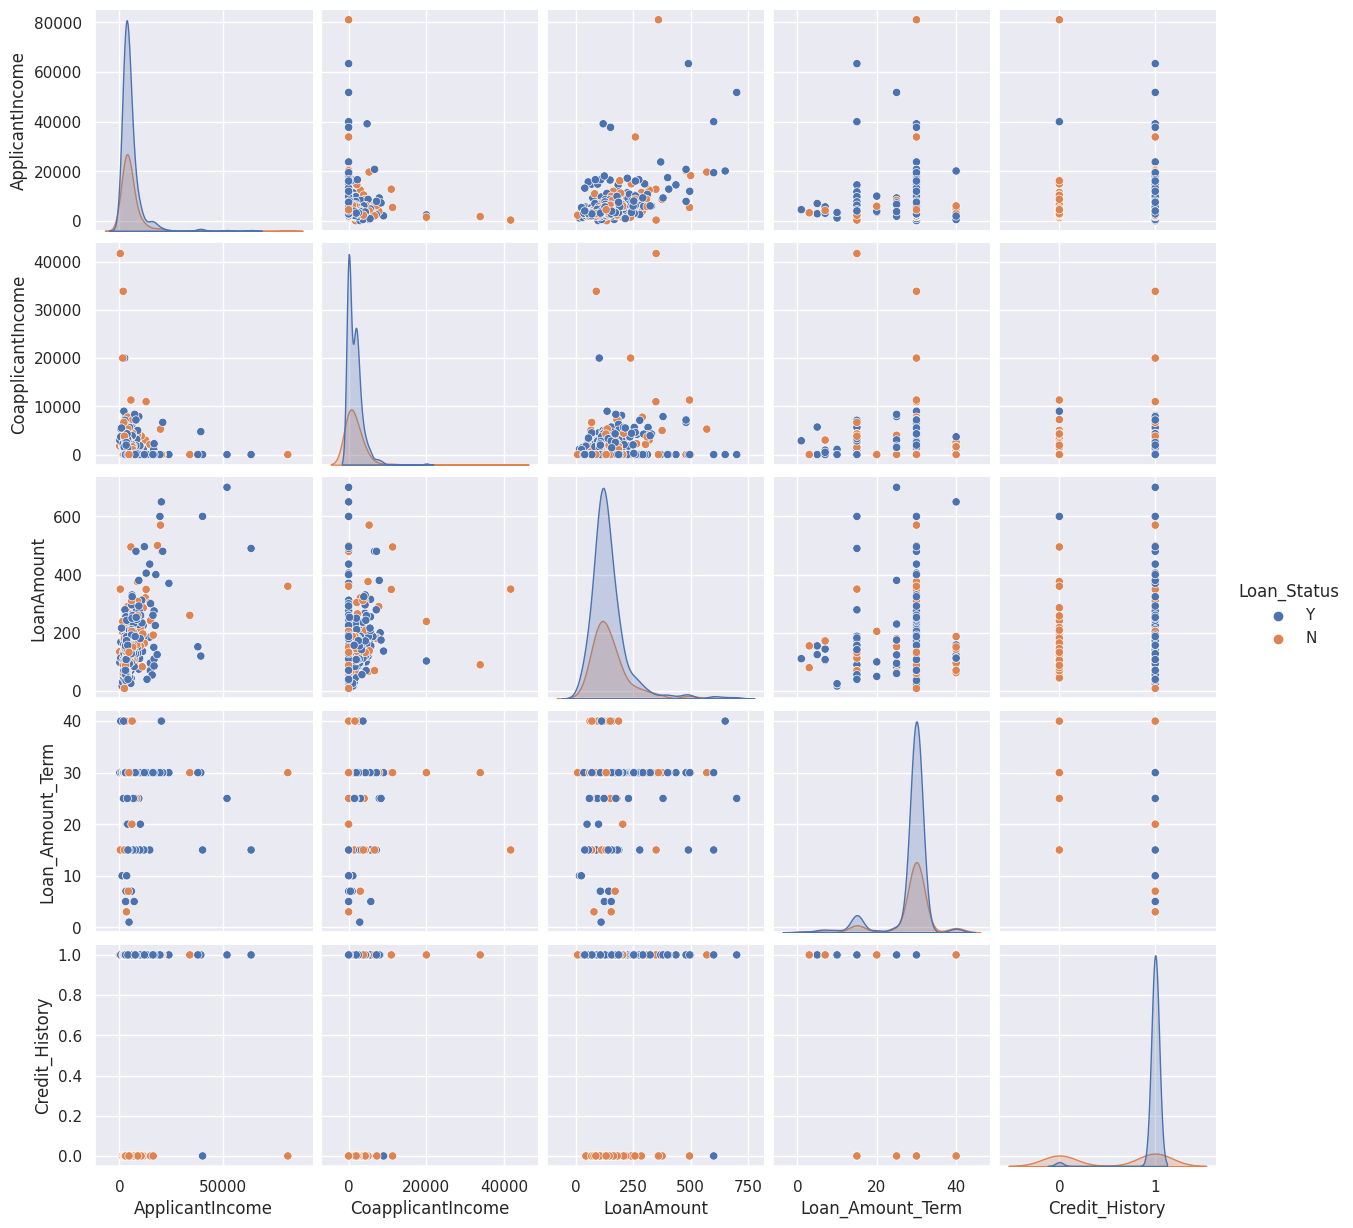

In [ ]:
sns.pairplot(df, hue='Loan_Status')

По сути, ничего нового мы не узнали: **Credit_History** сильно влияет на таргет, а любые остальные пары совокупностей никак не помогают.

В таком случае заполнение пропусков медианой для количественных и самым частым значением для категориальных вряд-ли сильно исказит какие-либо зависимости.

Итого, заполняем пропуски следующим образом:

+ Gender: 'Male'
+ Married: 'Yes'
+ Dependents: '0'
+ Self_Employed: 'No'
+ LoanAmount: mean
+ Loan_Amount_term: 360
+ Credit_History: kNN

## Пропуски в [Credit_History]

В отличие от остальных признаков, кредитная история достаточно сильно коррелирует с таргетом. Заполнять её простым методом не следует.

Попробуем разбораться с пропусками моделью "k ближайших соседей":

### [ВАРИАНТ 1] kNN

Следует подготовить заранее загруженный полный датасет (**fulldf**), натренировать на нём kNN, и использовать его для заполнения пропусков.

In [ ]:
# оригинальный датасет оставим, на всякий случай
fullknn = fulldf.copy()

Заранее поделим на выборки, во избежание утечки данных

In [ ]:
# отделяем выборку, на которой будет тренировка и валидация, от целевой выборки
knn_train = fullknn[~fullknn['Credit_History'].isna()]
knn_target = fullknn[fullknn['Credit_History'].isna()]

# в тренируемой выборке выделим таргет
knnX = knn_train.drop(columns='Credit_History')
knnY = knn_train['Credit_History']

# наконец разделим тренировочную и валидационную
knnX_train, knnX_test, knnY_train, knnY_test = train_test_split(knnX, knnY, test_size=0.33, random_state=42)

In [ ]:
print(len(knnX_train), len(knnX_test))

604 298


Сформируем пайплайн для kNN:

In [ ]:
# признаки для пайплайна:

# категориальные, заполняем самым частым
freq_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']

# численный признак - средним
mean_cols = ['LoanAmount']

# эти признаки лучше кодироать onehot
ohe_cols = ['Gender', 'Self_Employed']

# эти лучше кодировать порядково
ord_cols = ['Married', 'Dependents', 'Education', 'Property_Area']

# пайплайн
knnPipe = Pipeline([
    # 1. Заполнение пропусков
    ('simple_imputer', ColumnTransformer(transformers=[
    ('imputer1', SimpleImputer(strategy='most_frequent'), freq_cols),
    ('imputer2', SimpleImputer(strategy='mean'), mean_cols)],
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')),

    # 2. Выявление и удаление выбросов изолирующим лесом
    ('outlier_removal', FunctionSampler(func=isolationOutlierDetector, validate=False)),

    # 3. Кодирование категориальных признаков
    ('encoder', ColumnTransformer(transformers=[
                ('ord', OrdinalEncoder(), ord_cols),
                ('ohe', OneHotEncoder(sparse=False), ohe_cols)],
                remainder='passthrough')),

    # 4. Применение kNN
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

# Схема пайплайна:
knnPipe

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer1',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Gender', 'Married',
                                                   'Dependents',
                                                   'Self_Employed',
                                                   'Loan_Amount_Term']),
                                                 ('imputer2', SimpleImputer(),
                                                  ['LoanAmount'])],
                                   verbose_feature_names_out=False)),
                ('outlier_removal',
                 FunctionSampler(func=<function isolationOutlierDetector at 0x7ff05db62ca0>,
                                 validate=False)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['Married', 'Dependents',
                                                   'Education',
                                                   'Property_Area']),
                                                 ('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender',
                                                   'Self_Employed'])])),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

Для достижения оптимального результата гиперпараметры подберём автоматически полным перебором из некоторого дипапзона наиболее осмысленных значений:

In [ ]:
k_range = list(range(1, 30))
ps = [1, 2]
param_grid = dict(knn__n_neighbors=k_range, knn__p=ps)

knn = GridSearchCV(knnPipe, param_grid, cv=3, scoring='roc_auc',
                   return_train_score=False, verbose=1, n_jobs=-1)

Ведём поиск лучшей модели:

In [ ]:
knn.fit(knnX_train, knnY_train)

Fitting 3 folds for each of 58 candidates, totalling 174 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simple_imputer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer1',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Self_Employed',
                                                                          'Loan_Amount_Term']),
                                                                        ('imputer2',
                                                                         SimpleImputer(),
                                                                         ['LoanAmount'])],
                                                          verbose_feature_names_out=False)),
                                       ('outlier_removal',
                                        FunctionSamp...
                                                          transformers=[('ord',
                                                                         OrdinalEncoder(),
                                                                         ['Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Property_Area']),
                                                                        ('ohe',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Gender',
                                                                          'Self_Employed'])])),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=3))]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29],
                         'knn__p': [1, 2]},
             scoring='roc_auc', verbose=1)

Получаем лучшую модель:

In [ ]:
knn.best_params_

{'knn__n_neighbors': 2, 'knn__p': 2}

Получаем её предсказания:

In [ ]:
knnY_pred = knn.predict(knnX_test)

In [ ]:
# MSE
mean_squared_error(knnY_test, knnY_pred)

0.3724832214765101

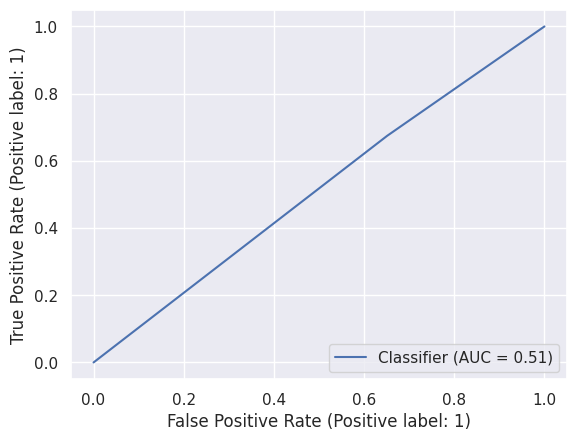

In [ ]:
# AUC-ROC
RocCurveDisplay.from_predictions(knnY_test, knnY_pred)

In [ ]:
# Прочие метрики
print(classification_report(knnY_test, knnY_pred))

              precision    recall  f1-score   support

         0.0       0.15      0.35      0.21        43
         1.0       0.86      0.67      0.76       255

    accuracy                           0.63       298
   macro avg       0.51      0.51      0.48       298
weighted avg       0.76      0.63      0.68       298



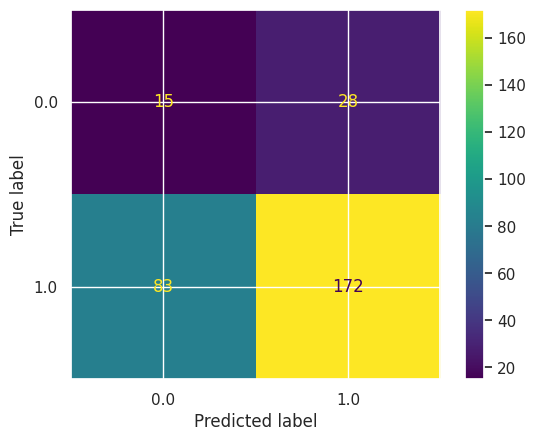

In [ ]:
# матрица ошибок
cm = confusion_matrix(knnY_test, knnY_pred, labels=knn.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_).plot()

Получается, kNN не может восстановить связь.
Это может означать, что между кредитной историей и прочими признаками нет зависимостей.

Попробуем применить более мощный метод с другим подходом - градиентный бустинг на решающих деревьях.

### [ВАРИАНТ 2] XGBoost

In [ ]:
# оригинальный датасет оставим, на всякий случай
fullxgb = fulldf.copy()

Заранее поделим на выборки, во избежание утечки данных

In [ ]:
# отделяем выборку, на которой будет тренировка и валидация, от целевой выборки
xgb_train = fullxgb[~fullxgb['Credit_History'].isna()]
xgb_target = fullxgb[fullxgb['Credit_History'].isna()]

# в тренирующей выборке выделим таргет
xgbX = xgb_train.drop(columns='Credit_History')
xgbY = xgb_train['Credit_History']

# наконец разделим тренировочную и валидационную
xgbX_train, xgbX_test, xgbY_train, xgbY_test = train_test_split(xgbX, xgbY, test_size=0.33, random_state=42)

In [ ]:
# строим пайплайн,
# для деревьев достаточно только закодировать категориальные признаки

ord_cols = ['Married', 'Dependents', 'Education', 'Property_Area', 'Gender', 'Self_Employed']

# пайплайн
xgbPipe = Pipeline([
    # 1. Закодируем всё порядково
    ('encoder', ColumnTransformer(transformers=[
                ('ord', OrdinalEncoder(), ord_cols)],
                remainder='passthrough')),
    # 2. XGBoost
    ('xgbcl', XGBClassifier())
])

В отличие от kNN, у этой модели относительно долгая тренировка и много гиперпараметров - поиск лучшего варианта полным перебором займёт чрезмерно много времени.

Будем настраивать бустинг через случайный поиск над кросс-валидацией.

Для этого:
1. прогоним ненастроенный пайплайн через этот метод поиска,
2. получим оптимальные гиперпараметры,
3. обучем модель с ними

In [ ]:
# переберём самые важные параметры в некотором диапазоне
params = {
 'xgbcl__learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 'xgbcl__max_depth' : [3, 4, 5, 6, 8, 10, 12, 15],
 'xgbcl__min_child_weight' : [1, 3, 5, 7],
 'xgbcl__gamma' : [0.0, 0.1, 0.2 , 0.3, 0.4],
 'xgbcl__colsample_bytree' : [0.3, 0.4, 0.5 , 0.7]
}

In [ ]:
# произведем поиск по ним
search = RandomizedSearchCV(xgbPipe, param_distributions=params, n_iter=50,
                            scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
search.fit(xgbX_train, xgbY_train)
# получим оптимальную модель
search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['Married', 'Dependents',
                                                   'Education', 'Property_Area',
                                                   'Gender',
                                                   'Self_Employed'])])),
                ('xgbcl',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.3, early_stopping_rounds=None,
                               e...
                               feature_types=None, gamma=0.0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
# предсказываем ей
xgbY_pred = search.predict(xgbX_test)

Смотрим метрики:

In [ ]:
mean_squared_error(xgbY_test, xgbY_pred)

0.19798657718120805

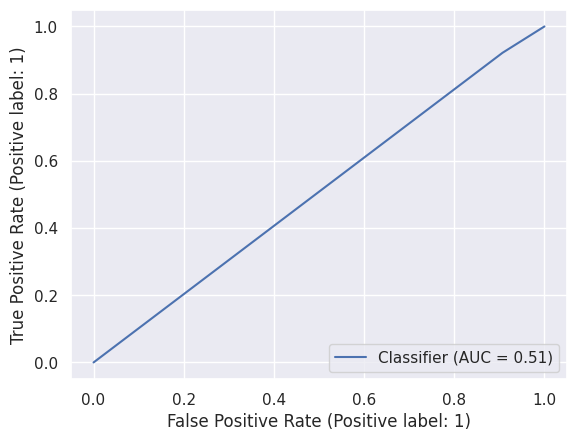

In [ ]:
RocCurveDisplay.from_predictions(xgbY_test, xgbY_pred)

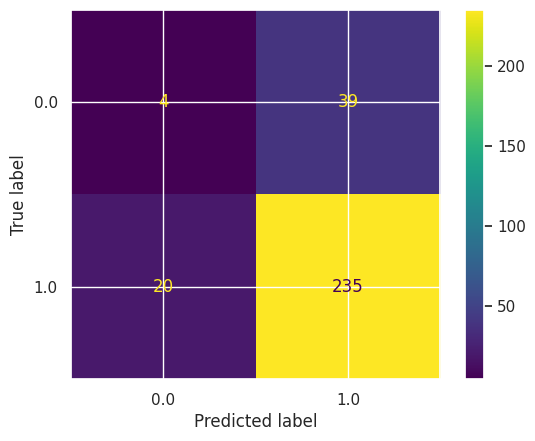

In [ ]:
cm = confusion_matrix(xgbY_test, xgbY_pred, labels=search.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=search.classes_).plot()

## Вывод по пропускам

Ни kNN, ни даже настроенный градиентный бустинг не смогли дать ROC-AUC значительно выше половины. Это значит, что кредитная история, судя по всему, практически не связана с другими признаками. В таком случае можно либо заполнить пропуски константой (в нашем случае - единицей), либо дропнуть.

# Обучение

Итак, анализ и подготовка данных завершены.

Далее - непосредственно обучение различных моделей и сравнение их эффективности.

Гиперпараметры, как и в моделях для пропусков, будем подбирать полным или случайным перебором над кросс-валидацией.

In [ ]:
# Сначала отделим таргет
X = df.drop(columns='Loan_Status')
y = df['Loan_Status']

# закодируем таргет
lab = LabelEncoder()
y = pd.DataFrame(lab.fit_transform(y))

# А также отделим тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Линейные модели

### Общий анализ

Для начала следует построить отдельный, общий пайплайн, который подготовит данные для любой линейной модели.

План:

- Количественные признаки по возможности лог-трансформировать
- Тривиальные пропуски заполнить
- Выбросы отобрать и удалить
- Категориальные закодировать каждый оптимальным способом:
 +  [Gender] - onehot
 +  [Married] - ordinal
 +  [Dependents] - ordinal
 +  [Education] - ordinal
 +  [Self_Employed] - onehot
 +  [Property_Area] - ordinal
 +  [Loan_Status] - ordinal
- [Loan_Amount_Term] разделить на 12 (уже выполнено)
- Остальное при необходимости скалировать

In [ ]:
# признаки для пайплайна:

# категориальные, заполняем самым частым
freq_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed',
             'Loan_Amount_Term', 'Credit_History']

# численный признак - средним
mean_cols = ['LoanAmount']

# эти признаки лучше кодироать onehot
ohe_cols = ['Gender', 'Self_Employed']

# эти лучше  кодировать порядково
ord_cols = ['Married', 'Dependents', 'Education', 'Property_Area']

# скалировать нужно только  один признак
scale_cols = ['CoapplicantIncome']

In [ ]:
linTransformerList = [
    # 1. Лог-трансформация
    ('log-transformer', FunctionTransformer(logApply, validate=False)),

    # 2. Заполнение пропусков
    ('simple_imputer', ColumnTransformer(transformers=[
    ('imputer1', SimpleImputer(strategy='most_frequent'), freq_cols),
    ('imputer2', SimpleImputer(strategy='mean'), mean_cols)],
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')),

    # 3. Выявление и удаление выбросов изолирующим лесом
    ('outlier_removal', FunctionSampler(func=isolationOutlierDetector, validate=False)),

    # 4. Кодирование категориальных признаков
    ('encoder', ColumnTransformer(transformers=[
                ('ord', OrdinalEncoder(), ord_cols),
                ('ohe', OneHotEncoder(sparse=False), ohe_cols)],
                remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')),

    # 5. Скалируем CoapplicantIncome
    ('scale_transformer', ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), scale_cols)],
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas'))
]

In [ ]:
# составим словарь линейных моделей для удобства
linear = {
    'logit' : LogisticRegression(),
    'ridge' : RidgeClassifier(),
    'sgd'   : SGDClassifier()
}

In [ ]:
# проверим их без настройки гиперпараметров, обучая кросс-валидацией
for name, model in linear.items():
    pipe = Pipeline(linTransformerList + [(name, model)])
    print(f'\n{name}:\n')
    acc = cross_val_score(pipe, X_train, y_train, cv=5)
    print('cv accuracy: ', acc)
    print('mean accuracy: ', acc.mean())
    roc = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    print('cv roc-auc : ', roc)
    print('mean roc-auc: ', roc.mean())


logit:

cv accuracy:  [0.8313253  0.81707317 0.79268293 0.76829268 0.80487805]
mean accuracy:  0.8028504260946224
cv roc-auc :  [0.76256614 0.7023569  0.67070707 0.67542088 0.7396978 ]
mean roc-auc:  0.7101497576497577

ridge:

cv accuracy:  [0.8313253  0.81707317 0.79268293 0.76829268 0.80487805]
mean accuracy:  0.8028504260946224
cv roc-auc :  [0.75793651 0.71043771 0.67272727 0.64579125 0.72527473]
mean roc-auc:  0.7024334924334925

sgd:

cv accuracy:  [0.81927711 0.69512195 0.75609756 0.34146341 0.80487805]
mean accuracy:  0.6833676168086982
cv roc-auc :  [0.75727513 0.6956229  0.66599327 0.6989899  0.71153846]
mean roc-auc:  0.7058839308839309


Для настройки и подробного рассмотрения из линейных моделей были выбраны логистическая регрессия и метод опорных векторов.

### Логистическая регрессия

Сначала проверим модель "из коробки", для сравнения.

In [ ]:
pipe = Pipeline(linTransformerList +
                [('logit', LogisticRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8226600985221675

In [ ]:
f1_score(y_test, y_pred)

0.888198757763975

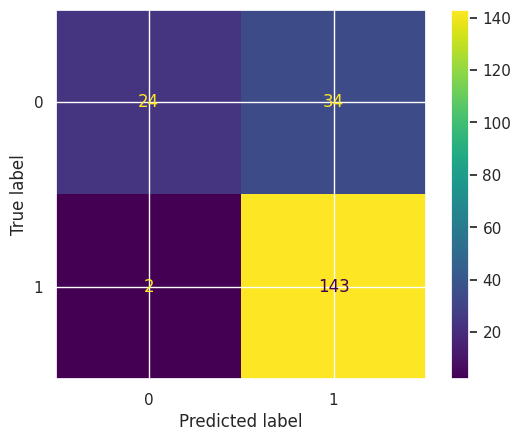

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

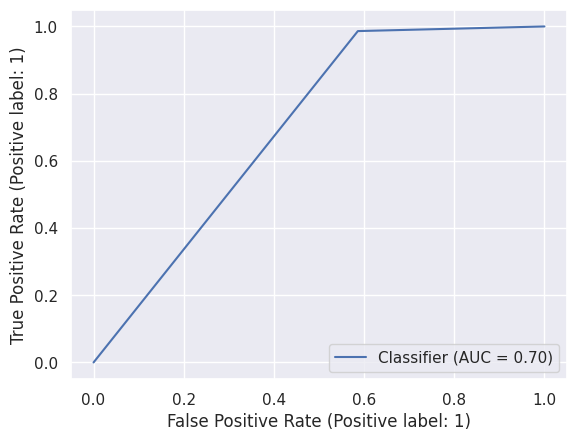

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

Подберём оптимальные гиперпараметры для логистической регрессии:

In [ ]:
#logit

params = {
    'logit__penalty'  : ['l1', 'l2', None],
    'logit__C'        : [1e-2, 1e-1, 1, 5],
    'logit__max_iter' : [50, 100, 500],
    'logit__l1_ratio' : [None, 0.1, 0.5, 0.9]
}

In [ ]:
pipe = Pipeline(linTransformerList + [('logit', LogisticRegression())])
# это займёт некоторое время
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'logit__C': 0.01,
 'logit__l1_ratio': None,
 'logit__max_iter': 50,
 'logit__penalty': None}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8177339901477833

In [ ]:
f1_score(y_test, y_pred)

0.8847352024922117

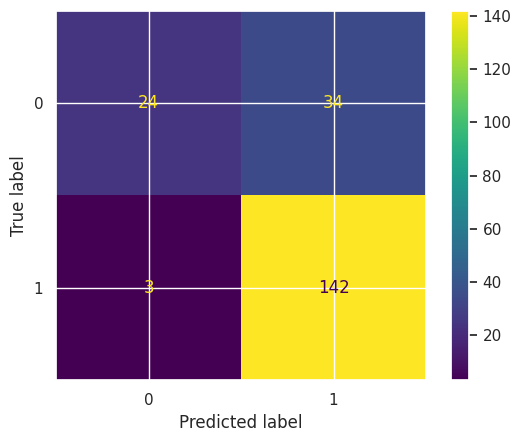

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

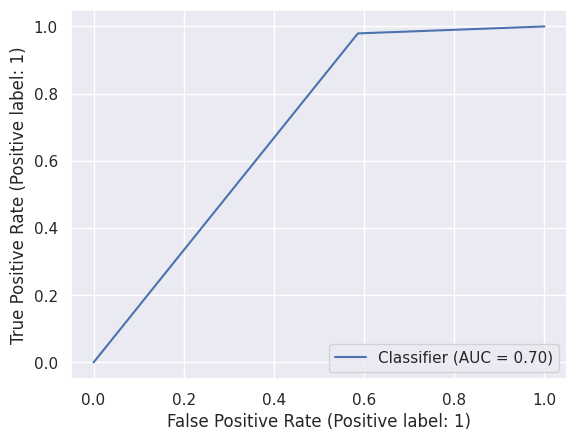

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

Признаки LoanAmount и ApplicantIncome ощутимо коррелируют (примерно на 52%).

Возможно, стоит обучить линейную модель без одного из них?

In [ ]:
pipe = Pipeline(linTransformerList + [('logit', LogisticRegression())])
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train.drop(columns='LoanAmount'), y_train)
search.best_params_

{'logit__C': 0.01,
 'logit__l1_ratio': None,
 'logit__max_iter': 50,
 'logit__penalty': None}

In [ ]:
y_pred = search.predict(X_test.drop(columns='LoanAmount'))

In [ ]:
accuracy_score(y_test, y_pred)

0.8177339901477833

In [ ]:
f1_score(y_test, y_pred)

0.8847352024922117

Модель получила ту же самую оценку.

### Метод опорных векторов

(было принято решение заменить SGDClassifier на его аналог SVC)

Сначала проверим модель "из коробки", для сравнения.

In [ ]:
pipe = Pipeline(linTransformerList +
               [('svc', SVC())])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7142857142857143

In [ ]:
f1_score(y_test, y_pred)

0.8333333333333333

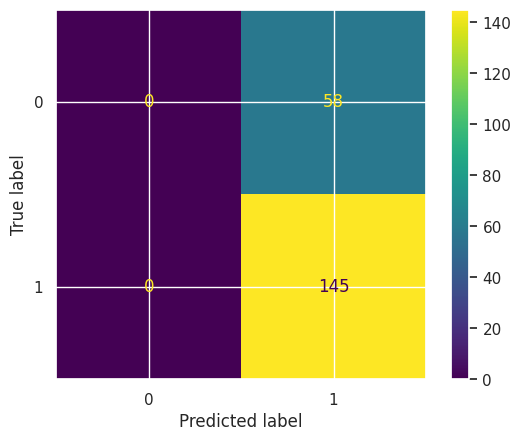

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

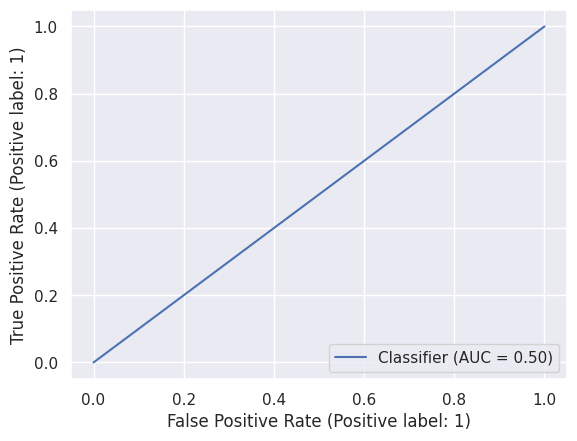

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

#### Линейное ядро

In [ ]:
#SVC

params = {
    'svc__C' : [1e-4, 1e-2, 1e-1, 1, 5, 50, 1e2, 1e3]
}

In [ ]:
pipe = Pipeline(linTransformerList +
               [('svc', SVC(kernel='linear'))])
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'svc__C': 0.1}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8226600985221675

In [ ]:
f1_score(y_test, y_pred)

0.888198757763975

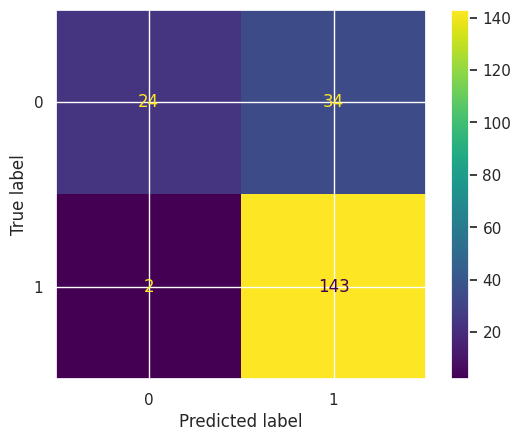

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

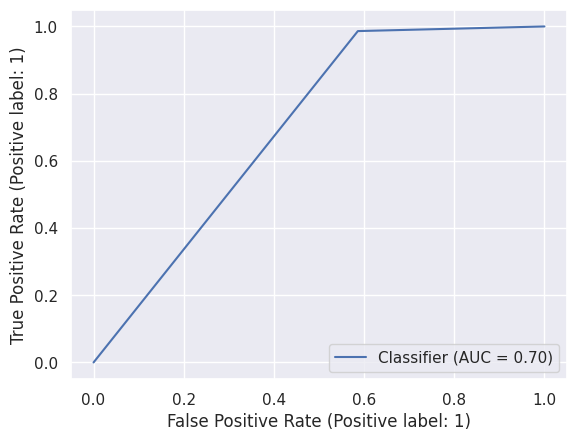

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

#### Ядро радиальной базисной функции

In [ ]:
pipe = Pipeline(linTransformerList +
               [('svc', SVC(kernel='rbf'))])
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'svc__C': 1000.0}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.812807881773399

In [ ]:
f1_score(y_test, y_pred)

0.8812500000000001

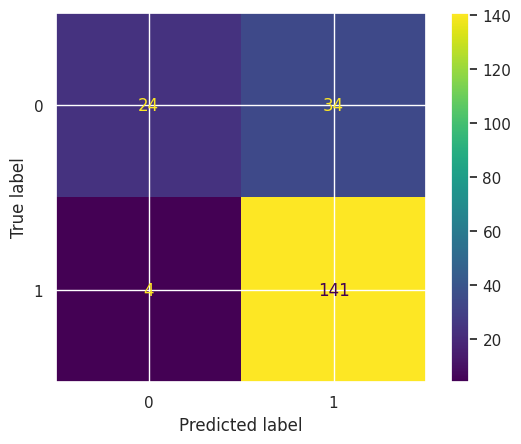

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

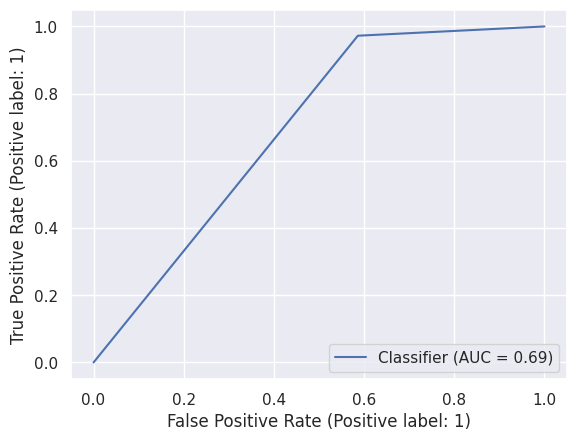

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

#### Сигмоидальное ядро

In [ ]:
params = dict({
    'svc__coef0': [-100, -50, -10, 0, 5, 50, 1e2, 1e3]
}, **params)

In [ ]:
pipe = Pipeline(linTransformerList +
               [('svc', SVC(kernel='sigmoid'))])
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'svc__C': 0.0001, 'svc__coef0': -100}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7142857142857143

In [ ]:
f1_score(y_test, y_pred)

0.8333333333333333

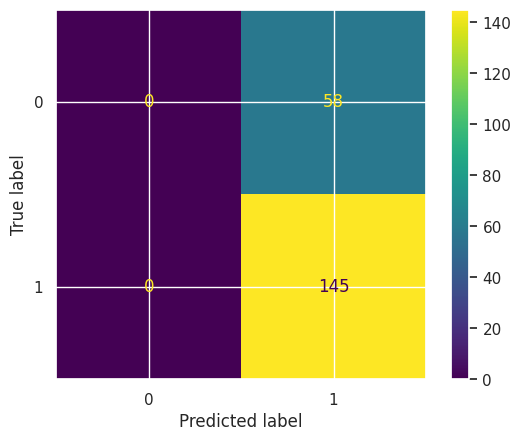

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

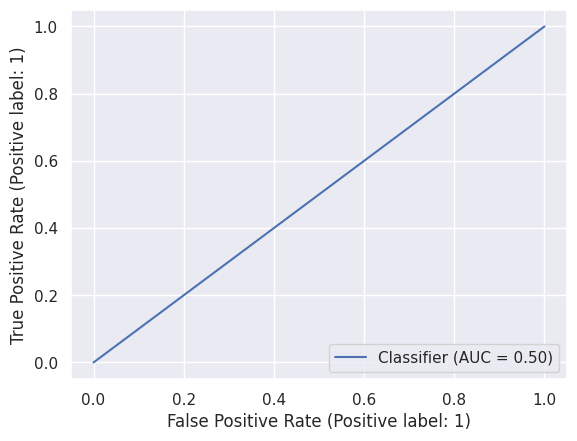

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

### Вывод по линейным моделям

|model|accuracy| f1| roc|
|---|---|---|---|
|logit| 0.817| 0.88| 0.7|
|svm lin| 0.823| 0.89| 0.7|
|svm rbf| 0.81| 0.88| 0.69|
|svm sigm| 0.71| 0.83| 0.5|

Как видим, из линейных моделей лучший результат показывает модель на SVM с линейным ядром.

## Решающее дерево

Сначала проверим модель "из коробки", для сравнения.

In [ ]:
pipe = Pipeline(linTransformerList +
                [('dt', DecisionTreeClassifier(random_state=42))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6945812807881774

In [ ]:
f1_score(y_test, y_pred)

0.7801418439716313

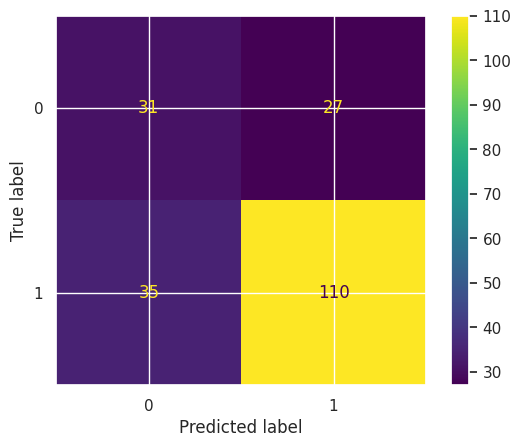

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

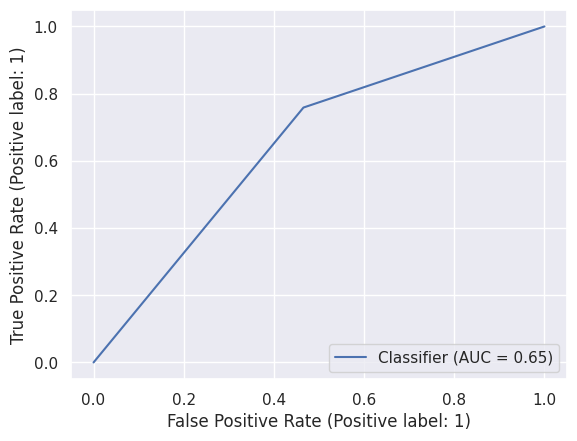

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

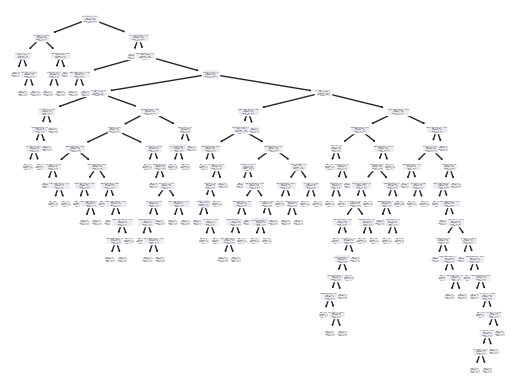

In [ ]:
tmp = pipe.named_steps['dt']
plot_tree(tmp, feature_names=tmp.feature_names_in_, class_names=tmp.classes_.astype(str));

Теперь подберем гиперпараметры

In [ ]:
params = {
  'dt__criterion': ['gini', 'entropy', 'log_loss'],
  'dt__splitter': ['best', 'random'],
  'dt__max_depth': [1, 2, 5, 10],

}

In [ ]:
pipe = Pipeline(linTransformerList +
                [('dt', DecisionTreeClassifier(random_state=42))])
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'dt__criterion': 'gini', 'dt__max_depth': 1, 'dt__splitter': 'best'}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8226600985221675

In [ ]:
f1_score(y_test, y_pred)

0.888198757763975

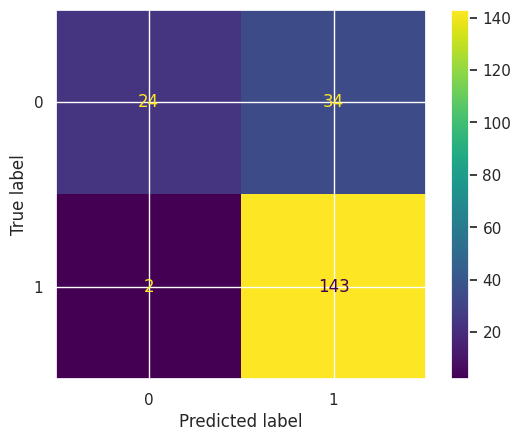

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

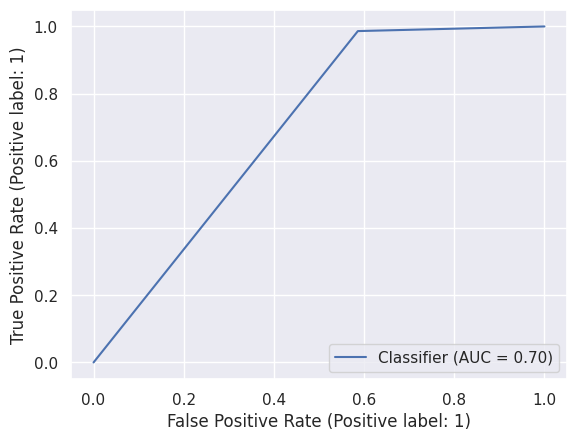

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

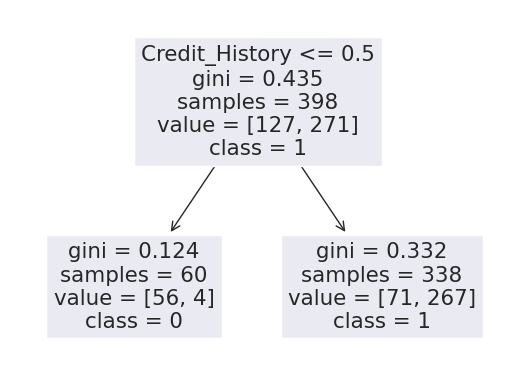

In [ ]:
tmp = search.best_estimator_.named_steps['dt']
plot_tree(tmp, feature_names=tmp.feature_names_in_, class_names=tmp.classes_.astype(str));

## HistGradientBoostingClassifier

In [ ]:
# строим пайплайн,
# для деревьев достаточно только закодировать категориальные признаки

ord_cols = ['Married', 'Dependents', 'Education', 'Property_Area', 'Gender', 'Self_Employed']

# пайплайн
pipe = Pipeline([
    # 1. Закодируем всё порядково
    ('encoder', ColumnTransformer(transformers=[
                ('ord', OrdinalEncoder(), ord_cols)],
                remainder='passthrough')),
    # 2. HistGradientBoost
    ('hgbcl', HistGradientBoostingClassifier())
])

Сначала проверим модель "из коробки", для сравнения.

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7881773399014779

In [ ]:
f1_score(y_test, y_pred)

0.8590163934426229

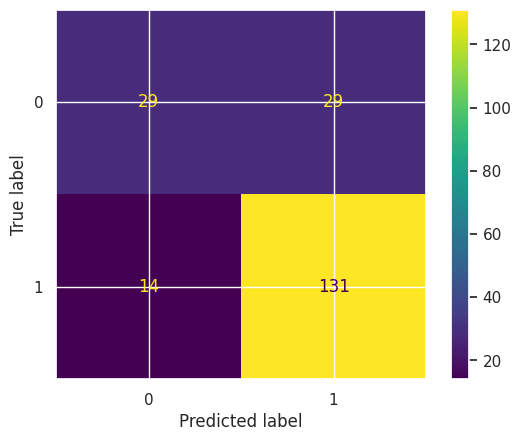

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

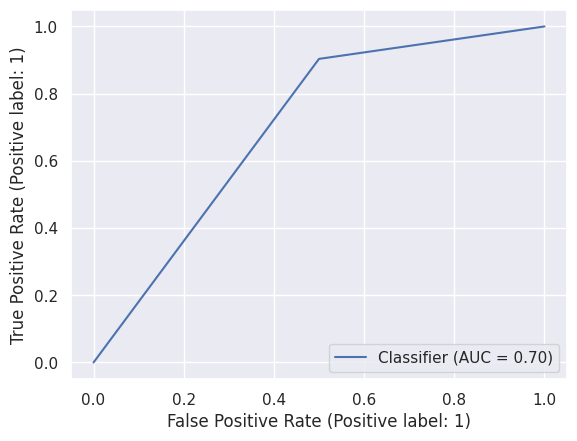

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [ ]:
# переберём самые важные параметры в некотором диапазоне
params = {
 'hgbcl__learning_rate' : [0.01, 0.1, 0.5, 1],
 'hgbcl__max_iter' : [50, 100, 500],
 'hgbcl__min_samples_leaf' : [10, 20, 30],
 'hgbcl__max_depth' : [None, 5, 10, 50],
 'hgbcl__max_leaf_nodes' : [None, 31, 100],
 'hgbcl__l2_regularization' : [0, 0.1, 0.5, 1]
}

In [ ]:
# произведем поиск по ним
search = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3,
                      n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'hgbcl__l2_regularization': 0,
 'hgbcl__learning_rate': 0.01,
 'hgbcl__max_depth': None,
 'hgbcl__max_iter': 50,
 'hgbcl__max_leaf_nodes': None,
 'hgbcl__min_samples_leaf': 10}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7931034482758621

In [ ]:
f1_score(y_test, y_pred)

0.8719512195121951

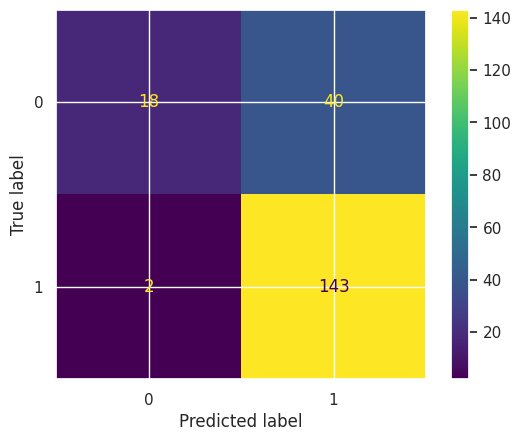

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

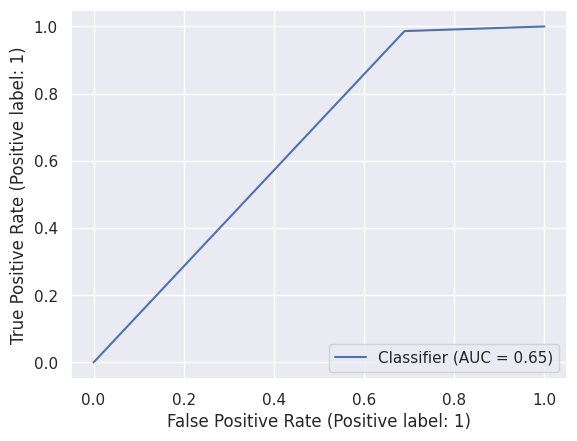

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

## Вывод по всем моделям

Сравним лучшую линейную модель с деревом и бустингом:

|model|accuracy| f1| roc|
|---|---|---|---|
|svm lin| 0.823| 0.89| 0.7|
|tree| 0.823| 0.89| 0.7|
|boost| 0.79| 0.87| 0.65|

Получается, SVM с линейным ядром остаётся лучшей моделью, а решающее дерево столь же качественно.